# Sarcasm detector
Ten notebook jest kontynuacją notebooka `sarcasm_detector_v1`, gdzie doszliśmy do wniosków, które wykorzystamy tutaj z nadzieją uzyskania jeszcze lepszych wyników.
### Wnioski z `sarcasm_detector_v1`:
- 1D ConvNet pozwala na osiągnięcie w miarę dobrego wyniku, nie przeucza się
- najlepiej spisał się LSTM, jednak towarzyszy mu duży overfitting. Przy czym można spróbować dodać regularyzację modelu
- lematyzacja jest nie potrzebna w tym problemie, prowadzi do utraty ważnych informacji, które ułatwiają wykrycie sarkazmu

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from keras import regularizers
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

## Definicja funkcji rysujących wykresy

In [4]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html

#def plt_inline():
#    rc = plt.rcParams.copy()
#    %matplotlib inline
#    plt.rcParams.update(rc)

def PlotAccuracyComparison(acc, val_acc, lab = ''):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train ' + lab, 'Test ' + lab], loc='upper left')
    plt.show()

def PlotLossComparison(loss, val_loss, lab = ''):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train ' + lab, 'Test ' + lab], loc='upper left')
    plt.show()

def PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train '+ lab1, 'Test ' + lab1, 'Train '+ lab2, 'Test ' + lab2], loc='upper left')
    plt.show()

def PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train '+ lab1, 'Test ' + lab1, 'Train '+ lab2, 'Test ' + lab2], loc='upper left')
    plt.show()

In [5]:
LABELS = ['Not sarcastic', 'Sarcastic']

# Define the confusion matrix for the results
def show_confusion_matrix(model):
    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)
    y_pred = y_pred.astype(int)
    y_pred = y_pred.flatten()
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    disp.plot()
    plt.show()

## Przygotowanie danych

In [6]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [7]:
stop_words = stopwords.words('english')

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [8]:
df = pd.read_json("dataset/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df = df.drop(columns=['article_link'])
df.drop_duplicates(inplace=True)
df['headline_clean'] = df['headline'].apply(clean_text)
df['headline_clean'] = df['headline_clean'].apply(remove_stopwords)

headers = df['headline_clean']
labels = df['is_sarcastic']
maxlen = 20
test_size = 0.2
max_words = 20000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(headers)
sequences = tokenizer.texts_to_sequences(headers)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42)

Found 28644 unique tokens.
Shape of data tensor: (28503, 20)
Shape of label tensor: (28503,)


#### Wczytanie GloVe 200D embeddings

In [9]:
glove_dir = '../../common/glove' 

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.300d.txt'), encoding ="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Zbudowanie macierzy osadzenia, która będziemy mogli załadować do warstwy Embedding

In [10]:
embedding_dim = 300

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

## GridSearchCV

In [13]:
# Function to create model, required for KerasClassifier
def create_model(units, neurons, dropout_rate, activation):
   model = Sequential()
   model.add(layers.Embedding(input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], input_length=maxlen))
   model.add(layers.LSTM(units))
   model.add(layers.Dropout(dropout_rate)) #+
   model.add(layers.Dense(neurons, activation=activation))
   model.add(layers.Dense(1, activation='sigmoid'))
 
   return model

# create model
model = KerasClassifier(model=create_model, loss="binary_crossentropy", batch_size=256, metrics=['acc'])
# define the grid search parameters
units = [16, 32, 64]
neurons = [8, 16, 32]
dropout_rate = [0.0, 0.3, 0.5]
activation = ['relu', 'elu']
optimizer = ['Nadam']
learn_rate = [0.0001, 0.001]
epochs = [10, 20]

param_grid = dict(model__units=units, model__neurons=neurons, model__dropout_rate=dropout_rate, model__activation=activation, optimizer=optimizer, optimizer__learning_rate=learn_rate, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=10)
grid_result = grid.fit(X_train, y_train, validation_split=0.2)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV 1/3; 1/216] START epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 5s 31ms/step - loss: 0.6948 - acc: 0.5048 - val_loss: 0.6925 - val_acc: 0.5196
Epoch 2/10
48/48 [==============================] - 1s 15ms/step - loss: 0.6835 - acc: 0.5690 - val_loss: 0.6806 - val_acc: 0.5797
Epoch 3/10
48/48 [==============================] - 1s 14ms/step - loss: 0.6706 - acc: 0.6235 - val_loss: 0.6672 - val_acc: 0.6238
Epoch 4/10
48/48 [==============================] - 1s 14ms/step - loss: 0.6545 - acc: 0.6542 - val_loss: 0.6505 - val_acc: 0.6593
Epoch 5/10
48/48 [==============================] - 1s 14ms/step - loss: 0.6338 - acc: 0.6827 - val_loss: 0.6296 - val_acc: 0.6764
Epoch 6/10
48/48 [==============================] - 1s 14ms/step - loss: 0.6086 - acc: 0.7045 - val_loss: 0.6053 - v

48/48 [==============================] - 1s 15ms/step - loss: 0.0311 - acc: 0.9926 - val_loss: 0.8285 - val_acc: 0.7807
Epoch 10/10
30/30 [==============================] - 1s 3ms/step
[CV 2/3; 2/216] END epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.790 total time=  11.5s
[CV 3/3; 2/216] START epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 5s 32ms/step - loss: 0.6594 - acc: 0.5986 - val_loss: 0.5934 - val_acc: 0.7116
Epoch 2/10
48/48 [==============================] - 1s 14ms/step - loss: 0.5147 - acc: 0.7689 - val_loss: 0.5132 - val_acc: 0.7747
Epoch 3/10
48/48 [==============================] - 1s 14ms/step - loss: 0.3703 - acc: 0.8530 - val_loss: 0.4563 - val_acc: 0.7882
Epoch 4/10
48/48 [==============================] - 1s 17ms/s

Epoch 6/10
48/48 [==============================] - 1s 16ms/step - loss: 0.0905 - acc: 0.9728 - val_loss: 0.6523 - val_acc: 0.7932
Epoch 7/10
48/48 [==============================] - 1s 17ms/step - loss: 0.0516 - acc: 0.9873 - val_loss: 0.7505 - val_acc: 0.7869
Epoch 8/10
48/48 [==============================] - 1s 17ms/step - loss: 0.0291 - acc: 0.9942 - val_loss: 0.8543 - val_acc: 0.7840
Epoch 9/10
48/48 [==============================] - 1s 16ms/step - loss: 0.0161 - acc: 0.9972 - val_loss: 0.9535 - val_acc: 0.7869
Epoch 10/10
30/30 [==============================] - 1s 3ms/step
[CV 1/3; 4/216] END epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.779 total time=  14.0s
[CV 2/3; 4/216] START epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] 

48/48 [==============================] - 1s 11ms/step - loss: 0.6677 - acc: 0.6067 - val_loss: 0.6467 - val_acc: 0.6534
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6280 - acc: 0.6725 - val_loss: 0.6036 - val_acc: 0.7004
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5815 - acc: 0.7066 - val_loss: 0.5602 - val_acc: 0.7221
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5367 - acc: 0.7354 - val_loss: 0.5251 - val_acc: 0.7478
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4966 - acc: 0.7619 - val_loss: 0.4996 - val_acc: 0.7593
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4633 - acc: 0.7853 - val_loss: 0.4900 - val_acc: 0.7675
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4349 - acc: 0.8026 - val_loss: 0.4723 - val_acc: 0.7738
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4125 - acc: 0.8136 

Epoch 1/10
48/48 [==============================] - 3s 19ms/step - loss: 0.6890 - acc: 0.5463 - val_loss: 0.6821 - val_acc: 0.5781
Epoch 2/10
48/48 [==============================] - 0s 10ms/step - loss: 0.6812 - acc: 0.5815 - val_loss: 0.6746 - val_acc: 0.6090
Epoch 3/10
48/48 [==============================] - 1s 10ms/step - loss: 0.6721 - acc: 0.6137 - val_loss: 0.6651 - val_acc: 0.6297
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6607 - acc: 0.6407 - val_loss: 0.6532 - val_acc: 0.6508
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6464 - acc: 0.6617 - val_loss: 0.6391 - val_acc: 0.6761
Epoch 6/10
48/48 [==============================] - 0s 10ms/step - loss: 0.6289 - acc: 0.6829 - val_loss: 0.6226 - val_acc: 0.6906
Epoch 7/10
48/48 [==============================] - 0s 10ms/step - loss: 0.6089 - acc: 0.7039 - val_loss: 0.6051 - val_acc: 0.7103
Epoch 8/10
48/48 [==============================] - 0s 10ms/step - loss: 0.5866 - a

30/30 [==============================] - 0s 2ms/step
[CV 3/3; 8/216] END epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.788 total time=   7.7s
[CV 1/3; 9/216] START epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6909 - acc: 0.5307 - val_loss: 0.6821 - val_acc: 0.5896
Epoch 2/10
48/48 [==============================] - 1s 10ms/step - loss: 0.6763 - acc: 0.5949 - val_loss: 0.6679 - val_acc: 0.6235
Epoch 3/10
48/48 [==============================] - 1s 13ms/step - loss: 0.6584 - acc: 0.6456 - val_loss: 0.6484 - val_acc: 0.6587
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6338 - acc: 0.6799 - val_loss: 0.6207 - val_acc: 0.6912
Epoch 5/10
48/48 [==============================] - 1s 11ms

48/48 [==============================] - 0s 11ms/step - loss: 0.0535 - acc: 0.9851 - val_loss: 0.7924 - val_acc: 0.7757
Epoch 8/10
48/48 [==============================] - 0s 10ms/step - loss: 0.0310 - acc: 0.9920 - val_loss: 1.4403 - val_acc: 0.6955
Epoch 9/10
48/48 [==============================] - 0s 11ms/step - loss: 0.0408 - acc: 0.9904 - val_loss: 0.9424 - val_acc: 0.7784
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 10/216] END epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.788 total time=   7.7s
[CV 3/3; 10/216] START epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.6217 - acc: 0.6552 - val_loss: 0.5170 - val_acc: 0.7507
Epoch 2/10
48/48 [==============================] - 1s 11

48/48 [==============================] - 1s 11ms/step - loss: 0.3045 - acc: 0.8716 - val_loss: 0.4482 - val_acc: 0.8004
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2057 - acc: 0.9222 - val_loss: 0.4887 - val_acc: 0.8083
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1290 - acc: 0.9564 - val_loss: 0.5977 - val_acc: 0.7981
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0723 - acc: 0.9772 - val_loss: 0.7484 - val_acc: 0.7886
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0447 - acc: 0.9878 - val_loss: 0.8428 - val_acc: 0.7941
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0268 - acc: 0.9939 - val_loss: 0.9771 - val_acc: 0.7971
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0534 - acc: 0.9860 - val_loss: 0.8821 - val_acc: 0.7948
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 12/216] END epochs=1

Epoch 1/10
48/48 [==============================] - 3s 19ms/step - loss: 0.6906 - acc: 0.5254 - val_loss: 0.6866 - val_acc: 0.5400
Epoch 2/10
48/48 [==============================] - 0s 11ms/step - loss: 0.6860 - acc: 0.5486 - val_loss: 0.6825 - val_acc: 0.5603
Epoch 3/10
48/48 [==============================] - 0s 10ms/step - loss: 0.6800 - acc: 0.5827 - val_loss: 0.6761 - val_acc: 0.5890
Epoch 4/10
48/48 [==============================] - 0s 10ms/step - loss: 0.6709 - acc: 0.6139 - val_loss: 0.6662 - val_acc: 0.6245
Epoch 5/10
48/48 [==============================] - 0s 10ms/step - loss: 0.6574 - acc: 0.6462 - val_loss: 0.6513 - val_acc: 0.6570
Epoch 6/10
48/48 [==============================] - 0s 11ms/step - loss: 0.6382 - acc: 0.6704 - val_loss: 0.6315 - val_acc: 0.6827
Epoch 7/10
48/48 [==============================] - 0s 10ms/step - loss: 0.6137 - acc: 0.6967 - val_loss: 0.6076 - val_acc: 0.6991
Epoch 8/10
48/48 [==============================] - 0s 10ms/step - loss: 0.5851 - a

30/30 [==============================] - 0s 2ms/step
[CV 1/3; 15/216] END epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.767 total time=   7.7s
[CV 2/3; 15/216] START epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.6915 - acc: 0.5250 - val_loss: 0.6836 - val_acc: 0.5692
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6808 - acc: 0.5859 - val_loss: 0.6722 - val_acc: 0.6143
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6654 - acc: 0.6268 - val_loss: 0.6532 - val_acc: 0.6550
Epoch 4/10
48/48 [==============================] - 0s 10ms/step - loss: 0.6391 - acc: 0.6694 - val_loss: 0.6213 - val_acc: 0.6906
Epoch 5/10
48/48 [==============================] - 0s 1

48/48 [==============================] - 0s 11ms/step - loss: 0.0417 - acc: 0.9893 - val_loss: 0.7954 - val_acc: 0.7909
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0221 - acc: 0.9953 - val_loss: 0.9247 - val_acc: 0.7912
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0406 - acc: 0.9893 - val_loss: 0.8164 - val_acc: 0.7879
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 16/216] END epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.793 total time=   7.7s
[CV 1/3; 17/216] START epochs=10, model__activation=relu, model__dropout_rate=0.0, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6847 - acc: 0.5524 - val_loss: 0.6719 - val_acc: 0.6100
Epoch 2/10
48/48 [==============================] - 1s 1

48/48 [==============================] - 1s 11ms/step - loss: 0.3137 - acc: 0.8681 - val_loss: 0.4390 - val_acc: 0.8027
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2151 - acc: 0.9169 - val_loss: 0.5164 - val_acc: 0.7925
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1371 - acc: 0.9497 - val_loss: 0.5813 - val_acc: 0.7978
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0810 - acc: 0.9731 - val_loss: 0.7093 - val_acc: 0.7879
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0420 - acc: 0.9869 - val_loss: 0.8777 - val_acc: 0.7895
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0181 - acc: 0.9961 - val_loss: 1.0462 - val_acc: 0.7833
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0092 - acc: 0.9984 - val_loss: 1.1894 - val_acc: 0.7869
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 18/216] END epochs=1

Epoch 1/10
48/48 [==============================] - 3s 19ms/step - loss: 0.6605 - acc: 0.6120 - val_loss: 0.5923 - val_acc: 0.7024
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5162 - acc: 0.7630 - val_loss: 0.4793 - val_acc: 0.7797
Epoch 3/10
48/48 [==============================] - 0s 10ms/step - loss: 0.3950 - acc: 0.8393 - val_loss: 0.4357 - val_acc: 0.8063
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2988 - acc: 0.8870 - val_loss: 0.4499 - val_acc: 0.8076
Epoch 5/10
48/48 [==============================] - 0s 11ms/step - loss: 0.2215 - acc: 0.9230 - val_loss: 0.4803 - val_acc: 0.8063
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1588 - acc: 0.9490 - val_loss: 0.5379 - val_acc: 0.8030
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1180 - acc: 0.9649 - val_loss: 0.6118 - val_acc: 0.8027
Epoch 8/10
48/48 [==============================] - 0s 10ms/step - loss: 0.0836 - a

30/30 [==============================] - 0s 2ms/step
[CV 2/3; 21/216] END epochs=10, model__activation=relu, model__dropout_rate=0.3, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.733 total time=   7.8s
[CV 3/3; 21/216] START epochs=10, model__activation=relu, model__dropout_rate=0.3, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6965 - acc: 0.4970 - val_loss: 0.6924 - val_acc: 0.5288
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6890 - acc: 0.5335 - val_loss: 0.6846 - val_acc: 0.5807
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6791 - acc: 0.5896 - val_loss: 0.6713 - val_acc: 0.6218
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6639 - acc: 0.6305 - val_loss: 0.6507 - val_acc: 0.6600
Epoch 5/10
48/48 [==============================] - 1s 11m

48/48 [==============================] - 1s 12ms/step - loss: 0.5001 - acc: 0.7589 - val_loss: 0.4981 - val_acc: 0.7622
Epoch 8/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4703 - acc: 0.7807 - val_loss: 0.4829 - val_acc: 0.7698
Epoch 9/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4450 - acc: 0.8012 - val_loss: 0.4716 - val_acc: 0.7744
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 23/216] END epochs=10, model__activation=relu, model__dropout_rate=0.3, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.769 total time=   8.2s
[CV 2/3; 23/216] START epochs=10, model__activation=relu, model__dropout_rate=0.3, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6948 - acc: 0.5058 - val_loss: 0.6868 - val_acc: 0.5679
Epoch 2/10
48/48 [==============================] - 1s 12

48/48 [==============================] - 1s 12ms/step - loss: 0.3411 - acc: 0.8548 - val_loss: 0.4416 - val_acc: 0.8037
Epoch 4/10
48/48 [==============================] - 1s 12ms/step - loss: 0.2475 - acc: 0.9011 - val_loss: 0.4767 - val_acc: 0.8004
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1714 - acc: 0.9368 - val_loss: 0.5188 - val_acc: 0.7971
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1247 - acc: 0.9566 - val_loss: 0.6191 - val_acc: 0.8030
Epoch 7/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0754 - acc: 0.9757 - val_loss: 0.7112 - val_acc: 0.7968
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0465 - acc: 0.9856 - val_loss: 0.8166 - val_acc: 0.7892
Epoch 9/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0312 - acc: 0.9919 - val_loss: 0.9364 - val_acc: 0.7935
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 24/216] END epochs=1

Epoch 1/10
48/48 [==============================] - 3s 19ms/step - loss: 0.6738 - acc: 0.5819 - val_loss: 0.6084 - val_acc: 0.6981
Epoch 2/10
48/48 [==============================] - 0s 10ms/step - loss: 0.5421 - acc: 0.7424 - val_loss: 0.4835 - val_acc: 0.7800
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4102 - acc: 0.8264 - val_loss: 0.4481 - val_acc: 0.7968
Epoch 4/10
48/48 [==============================] - 0s 11ms/step - loss: 0.3100 - acc: 0.8824 - val_loss: 0.4687 - val_acc: 0.7955
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2313 - acc: 0.9181 - val_loss: 0.4978 - val_acc: 0.8007
Epoch 6/10
48/48 [==============================] - 0s 10ms/step - loss: 0.1692 - acc: 0.9431 - val_loss: 0.5850 - val_acc: 0.7922
Epoch 7/10
48/48 [==============================] - 0s 11ms/step - loss: 0.1240 - acc: 0.9623 - val_loss: 0.6655 - val_acc: 0.7797
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0867 - a

30/30 [==============================] - 0s 2ms/step
[CV 3/3; 27/216] END epochs=10, model__activation=relu, model__dropout_rate=0.3, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.768 total time=   8.4s
[CV 1/3; 28/216] START epochs=10, model__activation=relu, model__dropout_rate=0.3, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 19ms/step - loss: 0.6411 - acc: 0.6344 - val_loss: 0.5464 - val_acc: 0.7274
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4747 - acc: 0.7782 - val_loss: 0.4779 - val_acc: 0.7701
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.3526 - acc: 0.8529 - val_loss: 0.4478 - val_acc: 0.7922
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2571 - acc: 0.8989 - val_loss: 0.5056 - val_acc: 0.7863
Epoch 5/10
48/48 [==============================] - 1s 11

48/48 [==============================] - 1s 12ms/step - loss: 0.4802 - acc: 0.7735 - val_loss: 0.4965 - val_acc: 0.7636
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4590 - acc: 0.7888 - val_loss: 0.4858 - val_acc: 0.7675
Epoch 9/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4343 - acc: 0.8018 - val_loss: 0.4769 - val_acc: 0.7744
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 29/216] END epochs=10, model__activation=relu, model__dropout_rate=0.3, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.769 total time=   8.6s
[CV 3/3; 29/216] START epochs=10, model__activation=relu, model__dropout_rate=0.3, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 22ms/step - loss: 0.6932 - acc: 0.5176 - val_loss: 0.6843 - val_acc: 0.5801
Epoch 2/10
48/48 [==============================] - 1s 

48/48 [==============================] - 1s 11ms/step - loss: 0.6804 - acc: 0.5669 - val_loss: 0.6766 - val_acc: 0.5916
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6727 - acc: 0.5970 - val_loss: 0.6684 - val_acc: 0.6228
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6630 - acc: 0.6248 - val_loss: 0.6568 - val_acc: 0.6426
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6483 - acc: 0.6525 - val_loss: 0.6411 - val_acc: 0.6600
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6283 - acc: 0.6797 - val_loss: 0.6201 - val_acc: 0.6741
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6028 - acc: 0.7044 - val_loss: 0.5966 - val_acc: 0.6912
Epoch 9/10
48/48 [==============================] - 0s 10ms/step - loss: 0.5749 - acc: 0.7271 - val_loss: 0.5722 - val_acc: 0.7123
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 31/216] END epochs=1

Epoch 1/10
48/48 [==============================] - 2s 19ms/step - loss: 0.6654 - acc: 0.5772 - val_loss: 0.5966 - val_acc: 0.7054
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5283 - acc: 0.7508 - val_loss: 0.5025 - val_acc: 0.7550
Epoch 3/10
48/48 [==============================] - 0s 10ms/step - loss: 0.3857 - acc: 0.8374 - val_loss: 0.4460 - val_acc: 0.8060
Epoch 4/10
48/48 [==============================] - 0s 11ms/step - loss: 0.2792 - acc: 0.8914 - val_loss: 0.4607 - val_acc: 0.8053
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2007 - acc: 0.9280 - val_loss: 0.5137 - val_acc: 0.7981
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1358 - acc: 0.9540 - val_loss: 0.5806 - val_acc: 0.7955
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0918 - acc: 0.9705 - val_loss: 0.7139 - val_acc: 0.7948
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0661 - a

30/30 [==============================] - 0s 2ms/step
[CV 1/3; 34/216] END epochs=10, model__activation=relu, model__dropout_rate=0.3, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.787 total time=   8.3s
[CV 2/3; 34/216] START epochs=10, model__activation=relu, model__dropout_rate=0.3, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6319 - acc: 0.6383 - val_loss: 0.5227 - val_acc: 0.7471
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4667 - acc: 0.7833 - val_loss: 0.4509 - val_acc: 0.7925
Epoch 3/10
48/48 [==============================] - 0s 11ms/step - loss: 0.3465 - acc: 0.8551 - val_loss: 0.4320 - val_acc: 0.8034
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2570 - acc: 0.8976 - val_loss: 0.4747 - val_acc: 0.7909
Epoch 5/10
48/48 [==============================] - 1s 11m

48/48 [==============================] - 1s 12ms/step - loss: 0.5013 - acc: 0.7609 - val_loss: 0.5036 - val_acc: 0.7639
Epoch 8/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4699 - acc: 0.7824 - val_loss: 0.4885 - val_acc: 0.7695
Epoch 9/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4420 - acc: 0.8012 - val_loss: 0.4795 - val_acc: 0.7747
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 35/216] END epochs=10, model__activation=relu, model__dropout_rate=0.3, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.776 total time=   8.6s
[CV 1/3; 36/216] START epochs=10, model__activation=relu, model__dropout_rate=0.3, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6084 - acc: 0.6621 - val_loss: 0.4986 - val_acc: 0.7547
Epoch 2/10
48/48 [==============================] - 1s 1

48/48 [==============================] - 0s 11ms/step - loss: 0.6863 - acc: 0.5724 - val_loss: 0.6813 - val_acc: 0.6205
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6810 - acc: 0.5997 - val_loss: 0.6748 - val_acc: 0.6491
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6752 - acc: 0.6112 - val_loss: 0.6660 - val_acc: 0.6662
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6642 - acc: 0.6442 - val_loss: 0.6541 - val_acc: 0.6764
Epoch 7/10
48/48 [==============================] - 0s 10ms/step - loss: 0.6541 - acc: 0.6590 - val_loss: 0.6401 - val_acc: 0.6932
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6388 - acc: 0.6809 - val_loss: 0.6236 - val_acc: 0.7040
Epoch 9/10
48/48 [==============================] - 0s 10ms/step - loss: 0.6229 - acc: 0.6957 - val_loss: 0.6058 - val_acc: 0.7116
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 37/216] END epochs=1

Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.6942 - acc: 0.5150 - val_loss: 0.6840 - val_acc: 0.5791
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6845 - acc: 0.5570 - val_loss: 0.6746 - val_acc: 0.6146
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6749 - acc: 0.5912 - val_loss: 0.6628 - val_acc: 0.6370
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6625 - acc: 0.6196 - val_loss: 0.6469 - val_acc: 0.6570
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6460 - acc: 0.6482 - val_loss: 0.6267 - val_acc: 0.6774
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6249 - acc: 0.6687 - val_loss: 0.6031 - val_acc: 0.7017
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5991 - acc: 0.6932 - val_loss: 0.5784 - val_acc: 0.7139
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5738 - a

30/30 [==============================] - 0s 2ms/step
[CV 2/3; 40/216] END epochs=10, model__activation=relu, model__dropout_rate=0.5, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.794 total time=   7.8s
[CV 3/3; 40/216] START epochs=10, model__activation=relu, model__dropout_rate=0.5, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6622 - acc: 0.5995 - val_loss: 0.5729 - val_acc: 0.7060
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5192 - acc: 0.7498 - val_loss: 0.4635 - val_acc: 0.7902
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4006 - acc: 0.8282 - val_loss: 0.4463 - val_acc: 0.7981
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.3075 - acc: 0.8771 - val_loss: 0.4714 - val_acc: 0.7984
Epoch 5/10
48/48 [==============================] - 1s 11ms/

48/48 [==============================] - 1s 11ms/step - loss: 0.0890 - acc: 0.9705 - val_loss: 0.7236 - val_acc: 0.7925
Epoch 8/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0653 - acc: 0.9800 - val_loss: 0.7819 - val_acc: 0.8030
Epoch 9/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0449 - acc: 0.9870 - val_loss: 0.9180 - val_acc: 0.7951
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 42/216] END epochs=10, model__activation=relu, model__dropout_rate=0.5, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.782 total time=   8.1s
[CV 2/3; 42/216] START epochs=10, model__activation=relu, model__dropout_rate=0.5, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 22ms/step - loss: 0.6395 - acc: 0.6274 - val_loss: 0.5415 - val_acc: 0.7333
Epoch 2/10
48/48 [==============================] - 1s 12ms

48/48 [==============================] - 1s 13ms/step - loss: 0.6862 - acc: 0.5520 - val_loss: 0.6821 - val_acc: 0.5866
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6818 - acc: 0.5610 - val_loss: 0.6765 - val_acc: 0.6113
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6755 - acc: 0.5845 - val_loss: 0.6691 - val_acc: 0.6278
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6670 - acc: 0.6062 - val_loss: 0.6588 - val_acc: 0.6498
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6563 - acc: 0.6254 - val_loss: 0.6445 - val_acc: 0.6672
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6444 - acc: 0.6420 - val_loss: 0.6286 - val_acc: 0.6833
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6292 - acc: 0.6608 - val_loss: 0.6116 - val_acc: 0.7034
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 43/216] END epochs=1

Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.7066 - acc: 0.4921 - val_loss: 0.6941 - val_acc: 0.4821
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6949 - acc: 0.5129 - val_loss: 0.6867 - val_acc: 0.5492
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6834 - acc: 0.5487 - val_loss: 0.6774 - val_acc: 0.6051
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6742 - acc: 0.5818 - val_loss: 0.6638 - val_acc: 0.6462
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6565 - acc: 0.6282 - val_loss: 0.6427 - val_acc: 0.6817
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6339 - acc: 0.6734 - val_loss: 0.6144 - val_acc: 0.6988
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6087 - acc: 0.6877 - val_loss: 0.5834 - val_acc: 0.7195
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5791 - a

30/30 [==============================] - 0s 2ms/step
[CV 3/3; 46/216] END epochs=10, model__activation=relu, model__dropout_rate=0.5, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.794 total time=   7.8s
[CV 1/3; 47/216] START epochs=10, model__activation=relu, model__dropout_rate=0.5, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6957 - acc: 0.5077 - val_loss: 0.6849 - val_acc: 0.5745
Epoch 2/10
48/48 [==============================] - 1s 12ms/step - loss: 0.6832 - acc: 0.5606 - val_loss: 0.6711 - val_acc: 0.6376
Epoch 3/10
48/48 [==============================] - 1s 12ms/step - loss: 0.6673 - acc: 0.6130 - val_loss: 0.6526 - val_acc: 0.6656
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6454 - acc: 0.6537 - val_loss: 0.6250 - val_acc: 0.6846
Epoch 5/10
48/48 [==============================] - 1s 12

48/48 [==============================] - 1s 11ms/step - loss: 0.0887 - acc: 0.9701 - val_loss: 0.7487 - val_acc: 0.7872
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0662 - acc: 0.9776 - val_loss: 0.6784 - val_acc: 0.7777
Epoch 9/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0469 - acc: 0.9859 - val_loss: 0.9704 - val_acc: 0.7826
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 48/216] END epochs=10, model__activation=relu, model__dropout_rate=0.5, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.790 total time=   8.1s
[CV 3/3; 48/216] START epochs=10, model__activation=relu, model__dropout_rate=0.5, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 31ms/step - loss: 0.6318 - acc: 0.6334 - val_loss: 0.5299 - val_acc: 0.7455
Epoch 2/10
48/48 [==============================] - 1s 11

48/48 [==============================] - 0s 10ms/step - loss: 0.4067 - acc: 0.8222 - val_loss: 0.4283 - val_acc: 0.8073
Epoch 4/10
48/48 [==============================] - 0s 11ms/step - loss: 0.3063 - acc: 0.8811 - val_loss: 0.4530 - val_acc: 0.7964
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2256 - acc: 0.9168 - val_loss: 0.5039 - val_acc: 0.7955
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1628 - acc: 0.9451 - val_loss: 0.5482 - val_acc: 0.8080
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1103 - acc: 0.9655 - val_loss: 0.6392 - val_acc: 0.7918
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0810 - acc: 0.9751 - val_loss: 0.7307 - val_acc: 0.7922
Epoch 9/10
48/48 [==============================] - 0s 11ms/step - loss: 0.0599 - acc: 0.9831 - val_loss: 0.8331 - val_acc: 0.7918
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 50/216] END epochs=1

Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.6875 - acc: 0.5453 - val_loss: 0.6799 - val_acc: 0.5965
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6783 - acc: 0.5821 - val_loss: 0.6693 - val_acc: 0.6241
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6677 - acc: 0.6120 - val_loss: 0.6560 - val_acc: 0.6564
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6547 - acc: 0.6325 - val_loss: 0.6382 - val_acc: 0.6708
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6368 - acc: 0.6527 - val_loss: 0.6150 - val_acc: 0.6876
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6105 - acc: 0.6818 - val_loss: 0.5883 - val_acc: 0.7093
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5852 - acc: 0.7022 - val_loss: 0.5631 - val_acc: 0.7221
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5606 - a

30/30 [==============================] - 0s 2ms/step
[CV 1/3; 53/216] END epochs=10, model__activation=relu, model__dropout_rate=0.5, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.766 total time=   8.2s
[CV 2/3; 53/216] START epochs=10, model__activation=relu, model__dropout_rate=0.5, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6940 - acc: 0.5185 - val_loss: 0.6837 - val_acc: 0.5860
Epoch 2/10
48/48 [==============================] - 1s 12ms/step - loss: 0.6796 - acc: 0.5786 - val_loss: 0.6676 - val_acc: 0.6511
Epoch 3/10
48/48 [==============================] - 1s 12ms/step - loss: 0.6618 - acc: 0.6323 - val_loss: 0.6420 - val_acc: 0.6807
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6306 - acc: 0.6731 - val_loss: 0.6000 - val_acc: 0.7034
Epoch 5/10
48/48 [==============================] - 1s 1

48/48 [==============================] - 1s 12ms/step - loss: 0.0795 - acc: 0.9728 - val_loss: 0.7435 - val_acc: 0.7918
Epoch 8/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0556 - acc: 0.9813 - val_loss: 0.8368 - val_acc: 0.7941
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0380 - acc: 0.9874 - val_loss: 0.9721 - val_acc: 0.7984
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 54/216] END epochs=10, model__activation=relu, model__dropout_rate=0.5, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.797 total time=   8.2s
[CV 1/3; 55/216] START epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 19ms/step - loss: 0.7011 - acc: 0.4988 - val_loss: 0.6948 - val_acc: 0.5179
Epoch 2/10
48/48 [==============================] - 0s 10m

Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2322 - acc: 0.9115 - val_loss: 0.4637 - val_acc: 0.7997
Epoch 5/10
48/48 [==============================] - 0s 10ms/step - loss: 0.1598 - acc: 0.9448 - val_loss: 0.5275 - val_acc: 0.7978
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1008 - acc: 0.9702 - val_loss: 0.6595 - val_acc: 0.7754
Epoch 7/10
48/48 [==============================] - 0s 10ms/step - loss: 0.0623 - acc: 0.9826 - val_loss: 0.7088 - val_acc: 0.7886
Epoch 8/10
48/48 [==============================] - 1s 10ms/step - loss: 0.0374 - acc: 0.9917 - val_loss: 0.8153 - val_acc: 0.7803
Epoch 9/10
48/48 [==============================] - 0s 10ms/step - loss: 0.0235 - acc: 0.9951 - val_loss: 0.8874 - val_acc: 0.7797
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 56/216] END epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learni

Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.6097 - acc: 0.6665 - val_loss: 0.5128 - val_acc: 0.7517
Epoch 2/10
48/48 [==============================] - 0s 11ms/step - loss: 0.4323 - acc: 0.8048 - val_loss: 0.4403 - val_acc: 0.7994
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.3116 - acc: 0.8710 - val_loss: 0.4335 - val_acc: 0.8043
Epoch 4/10
48/48 [==============================] - 0s 11ms/step - loss: 0.2087 - acc: 0.9245 - val_loss: 0.4761 - val_acc: 0.8024
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1334 - acc: 0.9545 - val_loss: 0.5504 - val_acc: 0.7935
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0737 - acc: 0.9790 - val_loss: 0.6789 - val_acc: 0.8034
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0443 - acc: 0.9895 - val_loss: 0.7856 - val_acc: 0.7991
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0270 - a

30/30 [==============================] - 0s 2ms/step
[CV 2/3; 59/216] END epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.778 total time=   8.1s
[CV 3/3; 59/216] START epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6847 - acc: 0.5525 - val_loss: 0.6665 - val_acc: 0.6067
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6491 - acc: 0.6430 - val_loss: 0.6308 - val_acc: 0.6715
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6082 - acc: 0.6908 - val_loss: 0.5864 - val_acc: 0.6968
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5622 - acc: 0.7193 - val_loss: 0.5455 - val_acc: 0.7284
Epoch 5/10
48/48 [==============================] - 1s 11ms/

48/48 [==============================] - 1s 11ms/step - loss: 0.5551 - acc: 0.7382 - val_loss: 0.5566 - val_acc: 0.7330
Epoch 8/10
48/48 [==============================] - 0s 10ms/step - loss: 0.5227 - acc: 0.7586 - val_loss: 0.5342 - val_acc: 0.7481
Epoch 9/10
48/48 [==============================] - 0s 11ms/step - loss: 0.4910 - acc: 0.7782 - val_loss: 0.5130 - val_acc: 0.7593
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 61/216] END epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.747 total time=   7.6s
[CV 2/3; 61/216] START epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 19ms/step - loss: 0.6919 - acc: 0.5317 - val_loss: 0.6856 - val_acc: 0.5501
Epoch 2/10
48/48 [==============================] - 0s 10

48/48 [==============================] - 1s 10ms/step - loss: 0.3221 - acc: 0.8662 - val_loss: 0.4344 - val_acc: 0.8053
Epoch 4/10
48/48 [==============================] - 0s 10ms/step - loss: 0.2254 - acc: 0.9141 - val_loss: 0.4616 - val_acc: 0.8043
Epoch 5/10
48/48 [==============================] - 0s 10ms/step - loss: 0.1470 - acc: 0.9493 - val_loss: 0.5268 - val_acc: 0.7968
Epoch 6/10
48/48 [==============================] - 1s 10ms/step - loss: 0.0896 - acc: 0.9736 - val_loss: 0.6078 - val_acc: 0.8011
Epoch 7/10
48/48 [==============================] - 0s 10ms/step - loss: 0.0517 - acc: 0.9851 - val_loss: 0.7356 - val_acc: 0.7895
Epoch 8/10
48/48 [==============================] - 0s 11ms/step - loss: 0.0299 - acc: 0.9933 - val_loss: 0.8185 - val_acc: 0.7941
Epoch 9/10
48/48 [==============================] - 1s 10ms/step - loss: 0.0160 - acc: 0.9973 - val_loss: 0.9137 - val_acc: 0.7905
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 62/216] END epochs=1

Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6123 - acc: 0.6602 - val_loss: 0.5200 - val_acc: 0.7471
Epoch 2/10
48/48 [==============================] - 1s 17ms/step - loss: 0.4346 - acc: 0.8004 - val_loss: 0.4457 - val_acc: 0.7892
Epoch 3/10
48/48 [==============================] - 1s 12ms/step - loss: 0.3099 - acc: 0.8722 - val_loss: 0.4485 - val_acc: 0.8001
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2173 - acc: 0.9191 - val_loss: 0.5199 - val_acc: 0.7797
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1326 - acc: 0.9553 - val_loss: 0.5844 - val_acc: 0.7905
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0750 - acc: 0.9782 - val_loss: 0.7243 - val_acc: 0.7886
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0422 - acc: 0.9889 - val_loss: 0.9013 - val_acc: 0.7843
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0224 - a

30/30 [==============================] - 0s 2ms/step
[CV 3/3; 65/216] END epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.784 total time=   8.1s
[CV 1/3; 66/216] START epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 22ms/step - loss: 0.5851 - acc: 0.6858 - val_loss: 0.4795 - val_acc: 0.7705
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4093 - acc: 0.8164 - val_loss: 0.4329 - val_acc: 0.7961
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2912 - acc: 0.8767 - val_loss: 0.4462 - val_acc: 0.8099
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1858 - acc: 0.9298 - val_loss: 0.5236 - val_acc: 0.7974
Epoch 5/10
48/48 [==============================] - 1s 11ms

48/48 [==============================] - 0s 10ms/step - loss: 0.5228 - acc: 0.7507 - val_loss: 0.5337 - val_acc: 0.7392
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4887 - acc: 0.7688 - val_loss: 0.5172 - val_acc: 0.7471
Epoch 9/10
48/48 [==============================] - 0s 10ms/step - loss: 0.4583 - acc: 0.7918 - val_loss: 0.4972 - val_acc: 0.7590
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 67/216] END epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.756 total time=   7.6s
[CV 3/3; 67/216] START epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 19ms/step - loss: 0.6900 - acc: 0.5324 - val_loss: 0.6803 - val_acc: 0.5689
Epoch 2/10
48/48 [==============================] - 1s 10

Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5945 - acc: 0.7051 - val_loss: 0.5824 - val_acc: 0.7116
Epoch 5/10
48/48 [==============================] - 1s 10ms/step - loss: 0.5521 - acc: 0.7313 - val_loss: 0.5470 - val_acc: 0.7284
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5115 - acc: 0.7569 - val_loss: 0.5196 - val_acc: 0.7465
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4749 - acc: 0.7776 - val_loss: 0.4981 - val_acc: 0.7590
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4441 - acc: 0.7952 - val_loss: 0.4832 - val_acc: 0.7701
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4180 - acc: 0.8110 - val_loss: 0.4752 - val_acc: 0.7744
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 69/216] END epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learn

Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.5964 - acc: 0.6774 - val_loss: 0.4897 - val_acc: 0.7738
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4175 - acc: 0.8108 - val_loss: 0.4387 - val_acc: 0.7978
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2993 - acc: 0.8752 - val_loss: 0.4402 - val_acc: 0.8017
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1973 - acc: 0.9233 - val_loss: 0.5004 - val_acc: 0.8057
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1225 - acc: 0.9567 - val_loss: 0.5711 - val_acc: 0.8047
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0668 - acc: 0.9790 - val_loss: 0.7087 - val_acc: 0.7951
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0326 - acc: 0.9914 - val_loss: 0.8472 - val_acc: 0.7958
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0160 - a

30/30 [==============================] - 0s 2ms/step
[CV 1/3; 72/216] END epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.769 total time=   8.1s
[CV 2/3; 72/216] START epochs=10, model__activation=elu, model__dropout_rate=0.0, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.5726 - acc: 0.6990 - val_loss: 0.4718 - val_acc: 0.7757
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4051 - acc: 0.8184 - val_loss: 0.4350 - val_acc: 0.7955
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2867 - acc: 0.8796 - val_loss: 0.4450 - val_acc: 0.8001
Epoch 4/10
48/48 [==============================] - 1s 12ms/step - loss: 0.1882 - acc: 0.9289 - val_loss: 0.5186 - val_acc: 0.7981
Epoch 5/10
48/48 [==============================] - 1s 11ms/

48/48 [==============================] - 1s 11ms/step - loss: 0.5791 - acc: 0.7123 - val_loss: 0.5737 - val_acc: 0.7185
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5575 - acc: 0.7272 - val_loss: 0.5560 - val_acc: 0.7290
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5318 - acc: 0.7482 - val_loss: 0.5374 - val_acc: 0.7392
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 73/216] END epochs=10, model__activation=elu, model__dropout_rate=0.3, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.756 total time=   7.9s
[CV 1/3; 74/216] START epochs=10, model__activation=elu, model__dropout_rate=0.3, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.6514 - acc: 0.6150 - val_loss: 0.5634 - val_acc: 0.7228
Epoch 2/10
48/48 [==============================] - 0s 11ms/

Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6419 - acc: 0.6605 - val_loss: 0.6295 - val_acc: 0.6764
Epoch 5/10
48/48 [==============================] - 1s 10ms/step - loss: 0.6151 - acc: 0.6903 - val_loss: 0.6020 - val_acc: 0.6942
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5824 - acc: 0.7155 - val_loss: 0.5727 - val_acc: 0.7119
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5521 - acc: 0.7351 - val_loss: 0.5456 - val_acc: 0.7290
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5204 - acc: 0.7553 - val_loss: 0.5224 - val_acc: 0.7402
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4909 - acc: 0.7762 - val_loss: 0.5080 - val_acc: 0.7484
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 75/216] END epochs=10, model__activation=elu, model__dropout_rate=0.3, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learni

Epoch 1/10
48/48 [==============================] - 3s 22ms/step - loss: 0.6788 - acc: 0.5683 - val_loss: 0.6612 - val_acc: 0.6258
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6516 - acc: 0.6401 - val_loss: 0.6329 - val_acc: 0.6639
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6174 - acc: 0.6797 - val_loss: 0.5962 - val_acc: 0.7001
Epoch 4/10
48/48 [==============================] - 1s 12ms/step - loss: 0.5783 - acc: 0.7113 - val_loss: 0.5584 - val_acc: 0.7254
Epoch 5/10
48/48 [==============================] - 1s 12ms/step - loss: 0.5401 - acc: 0.7336 - val_loss: 0.5278 - val_acc: 0.7438
Epoch 6/10
48/48 [==============================] - 1s 12ms/step - loss: 0.5066 - acc: 0.7551 - val_loss: 0.5054 - val_acc: 0.7544
Epoch 7/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4758 - acc: 0.7746 - val_loss: 0.4879 - val_acc: 0.7646
Epoch 8/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4525 - a

30/30 [==============================] - 0s 2ms/step
[CV 2/3; 78/216] END epochs=10, model__activation=elu, model__dropout_rate=0.3, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.798 total time=   8.7s
[CV 3/3; 78/216] START epochs=10, model__activation=elu, model__dropout_rate=0.3, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.5972 - acc: 0.6763 - val_loss: 0.4854 - val_acc: 0.7705
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4320 - acc: 0.8022 - val_loss: 0.4347 - val_acc: 0.7991
Epoch 3/10
48/48 [==============================] - 1s 12ms/step - loss: 0.3198 - acc: 0.8649 - val_loss: 0.4281 - val_acc: 0.8083
Epoch 4/10
48/48 [==============================] - 1s 12ms/step - loss: 0.2196 - acc: 0.9149 - val_loss: 0.4839 - val_acc: 0.8063
Epoch 5/10
48/48 [==============================] - 1s 12ms/st

48/48 [==============================] - 1s 11ms/step - loss: 0.0810 - acc: 0.9739 - val_loss: 0.7613 - val_acc: 0.7856
Epoch 8/10
48/48 [==============================] - 0s 10ms/step - loss: 0.0540 - acc: 0.9849 - val_loss: 0.8177 - val_acc: 0.7863
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0363 - acc: 0.9910 - val_loss: 0.9456 - val_acc: 0.7787
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 80/216] END epochs=10, model__activation=elu, model__dropout_rate=0.3, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.774 total time=   8.1s
[CV 2/3; 80/216] START epochs=10, model__activation=elu, model__dropout_rate=0.3, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.6451 - acc: 0.6338 - val_loss: 0.5729 - val_acc: 0.7060
Epoch 2/10
48/48 [==============================] - 1s 10ms

48/48 [==============================] - 1s 11ms/step - loss: 0.6460 - acc: 0.6455 - val_loss: 0.6292 - val_acc: 0.6830
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6177 - acc: 0.6746 - val_loss: 0.5980 - val_acc: 0.7024
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5866 - acc: 0.7018 - val_loss: 0.5693 - val_acc: 0.7215
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5533 - acc: 0.7266 - val_loss: 0.5419 - val_acc: 0.7327
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5194 - acc: 0.7481 - val_loss: 0.5181 - val_acc: 0.7498
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4909 - acc: 0.7701 - val_loss: 0.4989 - val_acc: 0.7599
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4644 - acc: 0.7863 - val_loss: 0.4864 - val_acc: 0.7698
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 81/216] END epochs=1

Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6864 - acc: 0.5506 - val_loss: 0.6662 - val_acc: 0.6130
Epoch 2/10
48/48 [==============================] - 1s 12ms/step - loss: 0.6532 - acc: 0.6359 - val_loss: 0.6340 - val_acc: 0.6649
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6197 - acc: 0.6722 - val_loss: 0.5945 - val_acc: 0.6948
Epoch 4/10
48/48 [==============================] - 1s 12ms/step - loss: 0.5788 - acc: 0.7019 - val_loss: 0.5551 - val_acc: 0.7215
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5374 - acc: 0.7346 - val_loss: 0.5232 - val_acc: 0.7455
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4995 - acc: 0.7585 - val_loss: 0.5022 - val_acc: 0.7544
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4711 - acc: 0.7791 - val_loss: 0.4850 - val_acc: 0.7646
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4454 - a

30/30 [==============================] - 0s 2ms/step
[CV 3/3; 84/216] END epochs=10, model__activation=elu, model__dropout_rate=0.3, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.789 total time=   8.1s
[CV 1/3; 85/216] START epochs=10, model__activation=elu, model__dropout_rate=0.3, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.6943 - acc: 0.5213 - val_loss: 0.6843 - val_acc: 0.5600
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6786 - acc: 0.5685 - val_loss: 0.6679 - val_acc: 0.6120
Epoch 3/10
48/48 [==============================] - 1s 10ms/step - loss: 0.6603 - acc: 0.6180 - val_loss: 0.6493 - val_acc: 0.6481
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6372 - acc: 0.6516 - val_loss: 0.6267 - val_acc: 0.6761
Epoch 5/10
48/48 [==============================] - 1s 11ms

48/48 [==============================] - 0s 10ms/step - loss: 0.0923 - acc: 0.9692 - val_loss: 0.7862 - val_acc: 0.7777
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0649 - acc: 0.9802 - val_loss: 0.8205 - val_acc: 0.7800
Epoch 9/10
48/48 [==============================] - 0s 11ms/step - loss: 0.0396 - acc: 0.9887 - val_loss: 0.9602 - val_acc: 0.7774
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 86/216] END epochs=10, model__activation=elu, model__dropout_rate=0.3, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.793 total time=   7.7s
[CV 3/3; 86/216] START epochs=10, model__activation=elu, model__dropout_rate=0.3, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.6355 - acc: 0.6349 - val_loss: 0.5394 - val_acc: 0.7350
Epoch 2/10
48/48 [==============================] - 1s 11ms

48/48 [==============================] - 1s 11ms/step - loss: 0.3281 - acc: 0.8640 - val_loss: 0.4280 - val_acc: 0.8014
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2319 - acc: 0.9076 - val_loss: 0.4708 - val_acc: 0.8017
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1524 - acc: 0.9456 - val_loss: 0.5547 - val_acc: 0.8053
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0990 - acc: 0.9674 - val_loss: 0.6677 - val_acc: 0.7945
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0621 - acc: 0.9818 - val_loss: 0.7949 - val_acc: 0.7932
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0368 - acc: 0.9898 - val_loss: 0.9267 - val_acc: 0.7955
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0263 - acc: 0.9931 - val_loss: 1.0531 - val_acc: 0.7882
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 88/216] END epochs=1

Epoch 1/10
48/48 [==============================] - 3s 21ms/step - loss: 0.6798 - acc: 0.5703 - val_loss: 0.6618 - val_acc: 0.6426
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6477 - acc: 0.6502 - val_loss: 0.6270 - val_acc: 0.6833
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6103 - acc: 0.6823 - val_loss: 0.5860 - val_acc: 0.7096
Epoch 4/10
48/48 [==============================] - 1s 12ms/step - loss: 0.5694 - acc: 0.7112 - val_loss: 0.5493 - val_acc: 0.7307
Epoch 5/10
48/48 [==============================] - 1s 12ms/step - loss: 0.5305 - acc: 0.7370 - val_loss: 0.5231 - val_acc: 0.7527
Epoch 6/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4972 - acc: 0.7594 - val_loss: 0.5028 - val_acc: 0.7613
Epoch 7/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4664 - acc: 0.7819 - val_loss: 0.4885 - val_acc: 0.7698
Epoch 8/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4398 - a

30/30 [==============================] - 0s 2ms/step
[CV 1/3; 91/216] END epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.728 total time=   7.7s
[CV 2/3; 91/216] START epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 19ms/step - loss: 0.6984 - acc: 0.5291 - val_loss: 0.6826 - val_acc: 0.5528
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6852 - acc: 0.5522 - val_loss: 0.6745 - val_acc: 0.5903
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6759 - acc: 0.5807 - val_loss: 0.6659 - val_acc: 0.6205
Epoch 4/10
48/48 [==============================] - 1s 10ms/step - loss: 0.6658 - acc: 0.5994 - val_loss: 0.6557 - val_acc: 0.6435
Epoch 5/10
48/48 [==============================] - 1s 11ms/

48/48 [==============================] - 1s 11ms/step - loss: 0.1273 - acc: 0.9581 - val_loss: 0.6099 - val_acc: 0.8024
Epoch 8/10
48/48 [==============================] - 0s 11ms/step - loss: 0.0921 - acc: 0.9709 - val_loss: 0.7309 - val_acc: 0.7932
Epoch 9/10
48/48 [==============================] - 0s 10ms/step - loss: 0.0677 - acc: 0.9800 - val_loss: 0.8070 - val_acc: 0.7918
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 92/216] END epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.790 total time=   7.7s
[CV 1/3; 93/216] START epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 30ms/step - loss: 0.6951 - acc: 0.5225 - val_loss: 0.6792 - val_acc: 0.5771
Epoch 2/10
48/48 [==============================] - 1s 11ms/

Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2778 - acc: 0.8886 - val_loss: 0.4480 - val_acc: 0.8043
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2085 - acc: 0.9218 - val_loss: 0.5289 - val_acc: 0.7902
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1449 - acc: 0.9502 - val_loss: 0.6009 - val_acc: 0.7905
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1024 - acc: 0.9662 - val_loss: 0.6774 - val_acc: 0.7905
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0721 - acc: 0.9774 - val_loss: 0.8182 - val_acc: 0.7826
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0524 - acc: 0.9842 - val_loss: 0.8924 - val_acc: 0.7800
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 94/216] END epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learni

Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.6107 - acc: 0.6558 - val_loss: 0.4944 - val_acc: 0.7639
Epoch 2/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4433 - acc: 0.7961 - val_loss: 0.4356 - val_acc: 0.7964
Epoch 3/10
48/48 [==============================] - 1s 12ms/step - loss: 0.3325 - acc: 0.8590 - val_loss: 0.4351 - val_acc: 0.7997
Epoch 4/10
48/48 [==============================] - 1s 12ms/step - loss: 0.2372 - acc: 0.9054 - val_loss: 0.4681 - val_acc: 0.8053
Epoch 5/10
48/48 [==============================] - 1s 12ms/step - loss: 0.1574 - acc: 0.9415 - val_loss: 0.5651 - val_acc: 0.8024
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1080 - acc: 0.9639 - val_loss: 0.6361 - val_acc: 0.8007
Epoch 7/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0671 - acc: 0.9796 - val_loss: 0.8632 - val_acc: 0.7780
Epoch 8/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0670 - a

30/30 [==============================] - 0s 2ms/step
[CV 2/3; 97/216] END epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.737 total time=   8.0s
[CV 3/3; 97/216] START epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.6925 - acc: 0.5213 - val_loss: 0.6843 - val_acc: 0.5715
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6848 - acc: 0.5472 - val_loss: 0.6760 - val_acc: 0.6031
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6759 - acc: 0.5824 - val_loss: 0.6665 - val_acc: 0.6330
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6677 - acc: 0.6025 - val_loss: 0.6557 - val_acc: 0.6472
Epoch 5/10
48/48 [==============================] - 1s 11m

48/48 [==============================] - 1s 11ms/step - loss: 0.5663 - acc: 0.7127 - val_loss: 0.5506 - val_acc: 0.7280
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5394 - acc: 0.7343 - val_loss: 0.5294 - val_acc: 0.7438
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5098 - acc: 0.7550 - val_loss: 0.5106 - val_acc: 0.7540
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 99/216] END epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.750 total time=   8.0s
[CV 2/3; 99/216] START epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.7010 - acc: 0.5272 - val_loss: 0.6767 - val_acc: 0.5820
Epoch 2/10
48/48 [==============================] - 1s 11

48/48 [==============================] - 1s 11ms/step - loss: 0.3629 - acc: 0.8473 - val_loss: 0.4449 - val_acc: 0.8053
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2726 - acc: 0.8910 - val_loss: 0.4629 - val_acc: 0.8070
Epoch 5/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1927 - acc: 0.9262 - val_loss: 0.5149 - val_acc: 0.8109
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.1331 - acc: 0.9528 - val_loss: 0.6474 - val_acc: 0.7968
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0885 - acc: 0.9700 - val_loss: 0.7379 - val_acc: 0.8034
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0562 - acc: 0.9833 - val_loss: 0.8575 - val_acc: 0.7935
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0401 - acc: 0.9876 - val_loss: 0.9066 - val_acc: 0.7997
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 100/216] END epochs=

Epoch 1/10
48/48 [==============================] - 3s 22ms/step - loss: 0.6071 - acc: 0.6602 - val_loss: 0.4935 - val_acc: 0.7622
Epoch 2/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4422 - acc: 0.7928 - val_loss: 0.4406 - val_acc: 0.7951
Epoch 3/10
48/48 [==============================] - 1s 12ms/step - loss: 0.3327 - acc: 0.8590 - val_loss: 0.4486 - val_acc: 0.7961
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2438 - acc: 0.9039 - val_loss: 0.4752 - val_acc: 0.7991
Epoch 5/10
48/48 [==============================] - 1s 12ms/step - loss: 0.1691 - acc: 0.9386 - val_loss: 0.5510 - val_acc: 0.7902
Epoch 6/10
48/48 [==============================] - 1s 12ms/step - loss: 0.1124 - acc: 0.9611 - val_loss: 0.6737 - val_acc: 0.7840
Epoch 7/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0744 - acc: 0.9763 - val_loss: 0.7832 - val_acc: 0.7869
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0462 - a

30/30 [==============================] - 0s 2ms/step
[CV 3/3; 103/216] END epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.753 total time=   7.8s
[CV 1/3; 104/216] START epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.6612 - acc: 0.5978 - val_loss: 0.5762 - val_acc: 0.7077
Epoch 2/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5097 - acc: 0.7562 - val_loss: 0.4675 - val_acc: 0.7856
Epoch 3/10
48/48 [==============================] - 1s 11ms/step - loss: 0.3873 - acc: 0.8342 - val_loss: 0.4385 - val_acc: 0.7984
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2956 - acc: 0.8804 - val_loss: 0.4531 - val_acc: 0.8027
Epoch 5/10
48/48 [==============================] - 1s 11

48/48 [==============================] - 1s 11ms/step - loss: 0.5493 - acc: 0.7294 - val_loss: 0.5424 - val_acc: 0.7333
Epoch 8/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5221 - acc: 0.7473 - val_loss: 0.5231 - val_acc: 0.7399
Epoch 9/10
48/48 [==============================] - 1s 11ms/step - loss: 0.4940 - acc: 0.7700 - val_loss: 0.5076 - val_acc: 0.7527
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 105/216] END epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.755 total time=   7.8s
[CV 3/3; 105/216] START epochs=10, model__activation=elu, model__dropout_rate=0.5, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/10
48/48 [==============================] - 3s 20ms/step - loss: 0.7043 - acc: 0.5037 - val_loss: 0.6887 - val_acc: 0.5383
Epoch 2/10
48/48 [==============================] - 1s 

48/48 [==============================] - 1s 12ms/step - loss: 0.6408 - acc: 0.6542 - val_loss: 0.6150 - val_acc: 0.6939
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.6028 - acc: 0.6852 - val_loss: 0.5721 - val_acc: 0.7083
Epoch 5/10
48/48 [==============================] - 1s 12ms/step - loss: 0.5625 - acc: 0.7165 - val_loss: 0.5404 - val_acc: 0.7304
Epoch 6/10
48/48 [==============================] - 1s 11ms/step - loss: 0.5292 - acc: 0.7410 - val_loss: 0.5135 - val_acc: 0.7461
Epoch 7/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4954 - acc: 0.7627 - val_loss: 0.4935 - val_acc: 0.7557
Epoch 8/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4715 - acc: 0.7790 - val_loss: 0.4792 - val_acc: 0.7629
Epoch 9/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4470 - acc: 0.7962 - val_loss: 0.4691 - val_acc: 0.7724
Epoch 10/10
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 107/216] END epochs=

Epoch 1/10
48/48 [==============================] - 3s 22ms/step - loss: 0.6099 - acc: 0.6615 - val_loss: 0.4963 - val_acc: 0.7646
Epoch 2/10
48/48 [==============================] - 1s 12ms/step - loss: 0.4432 - acc: 0.7965 - val_loss: 0.4434 - val_acc: 0.7945
Epoch 3/10
48/48 [==============================] - 1s 12ms/step - loss: 0.3321 - acc: 0.8593 - val_loss: 0.4523 - val_acc: 0.8034
Epoch 4/10
48/48 [==============================] - 1s 11ms/step - loss: 0.2416 - acc: 0.9043 - val_loss: 0.4904 - val_acc: 0.8093
Epoch 5/10
48/48 [==============================] - 1s 12ms/step - loss: 0.1617 - acc: 0.9402 - val_loss: 0.5560 - val_acc: 0.8001
Epoch 6/10
48/48 [==============================] - 1s 12ms/step - loss: 0.1019 - acc: 0.9656 - val_loss: 0.7221 - val_acc: 0.7948
Epoch 7/10
48/48 [==============================] - 1s 11ms/step - loss: 0.0669 - acc: 0.9779 - val_loss: 0.8016 - val_acc: 0.7961
Epoch 8/10
48/48 [==============================] - 1s 12ms/step - loss: 0.0442 - a

Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6488 - acc: 0.6559 - val_loss: 0.6453 - val_acc: 0.6577
Epoch 5/20
48/48 [==============================] - 0s 10ms/step - loss: 0.6282 - acc: 0.6791 - val_loss: 0.6262 - val_acc: 0.6781
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6040 - acc: 0.7025 - val_loss: 0.6052 - val_acc: 0.6935
Epoch 7/20
48/48 [==============================] - 0s 10ms/step - loss: 0.5776 - acc: 0.7221 - val_loss: 0.5835 - val_acc: 0.7129
Epoch 8/20
48/48 [==============================] - 0s 11ms/step - loss: 0.5496 - acc: 0.7402 - val_loss: 0.5626 - val_acc: 0.7267
Epoch 9/20
48/48 [==============================] - 0s 10ms/step - loss: 0.5206 - acc: 0.7603 - val_loss: 0.5428 - val_acc: 0.7415
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4915 - acc: 0.7802 - val_loss: 0.5256 - val_acc: 0.7504
Epoch 11/20
48/48 [==============================] - 0s 11ms/step - loss: 0.4636 -

Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 110/216] END epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.788 total time=  12.8s
[CV 3/3; 110/216] START epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6494 - acc: 0.6167 - val_loss: 0.5678 - val_acc: 0.7238
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4842 - acc: 0.7773 - val_loss: 0.4856 - val_acc: 0.7672
Epoch 3/20
48/48 [==============================] - 0s 11ms/step - loss: 0.3388 - acc: 0.8601 - val_loss: 0.4587 - val_acc: 0.8017
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2340 - acc: 0.9130 - val_loss: 0.4660 - val_acc: 0.7981
Epoch 5/20
48/48 [============================

Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3896 - acc: 0.8387 - val_loss: 0.4724 - val_acc: 0.7761
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3691 - acc: 0.8506 - val_loss: 0.4715 - val_acc: 0.7774
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3500 - acc: 0.8622 - val_loss: 0.4650 - val_acc: 0.7810
Epoch 16/20
48/48 [==============================] - 0s 11ms/step - loss: 0.3322 - acc: 0.8699 - val_loss: 0.4648 - val_acc: 0.7826
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3148 - acc: 0.8797 - val_loss: 0.4664 - val_acc: 0.7846
Epoch 18/20
48/48 [==============================] - 0s 11ms/step - loss: 0.2985 - acc: 0.8876 - val_loss: 0.4637 - val_acc: 0.7886
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2823 - acc: 0.8958 - val_loss: 0.4679 - val_acc: 0.7938
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 11

48/48 [==============================] - 1s 11ms/step - loss: 0.1531 - acc: 0.9475 - val_loss: 0.5456 - val_acc: 0.7925
Epoch 6/20
48/48 [==============================] - 1s 10ms/step - loss: 0.0963 - acc: 0.9719 - val_loss: 0.6335 - val_acc: 0.7876
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0563 - acc: 0.9857 - val_loss: 0.7825 - val_acc: 0.7695
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0369 - acc: 0.9908 - val_loss: 0.8158 - val_acc: 0.7853
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0211 - acc: 0.9959 - val_loss: 0.9959 - val_acc: 0.7721
Epoch 10/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0149 - acc: 0.9970 - val_loss: 0.9870 - val_acc: 0.7797
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0093 - acc: 0.9983 - val_loss: 1.0468 - val_acc: 0.7774
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0057 - acc: 0.99

30/30 [==============================] - 0s 2ms/step
[CV 1/3; 113/216] END epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.796 total time=  13.5s
[CV 2/3; 113/216] START epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 21ms/step - loss: 0.6919 - acc: 0.5226 - val_loss: 0.6771 - val_acc: 0.5916
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6625 - acc: 0.6221 - val_loss: 0.6442 - val_acc: 0.6610
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6224 - acc: 0.6776 - val_loss: 0.6011 - val_acc: 0.6958
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5770 - acc: 0.7136 - val_loss: 0.5602 - val_acc: 0.7090
Epoch 5/20
48/48 [==============================] - 1s 1

Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0075 - acc: 0.9982 - val_loss: 1.2464 - val_acc: 0.7892
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0043 - acc: 0.9993 - val_loss: 1.2899 - val_acc: 0.7886
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0021 - acc: 0.9996 - val_loss: 1.3234 - val_acc: 0.7859
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0012 - acc: 0.9999 - val_loss: 1.4319 - val_acc: 0.7899
Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 7.1293e-04 - acc: 0.9999 - val_loss: 1.4881 - val_acc: 0.7895
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 6.0631e-04 - acc: 0.9999 - val_loss: 1.4480 - val_acc: 0.7872
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 114/216] END epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=8, model__units=64, optimizer=Nadam, o

48/48 [==============================] - 1s 11ms/step - loss: 0.6107 - acc: 0.6958 - val_loss: 0.6071 - val_acc: 0.6942
Epoch 7/20
48/48 [==============================] - 0s 10ms/step - loss: 0.5851 - acc: 0.7163 - val_loss: 0.5855 - val_acc: 0.7103
Epoch 8/20
48/48 [==============================] - 0s 10ms/step - loss: 0.5570 - acc: 0.7357 - val_loss: 0.5632 - val_acc: 0.7205
Epoch 9/20
48/48 [==============================] - 0s 10ms/step - loss: 0.5272 - acc: 0.7564 - val_loss: 0.5402 - val_acc: 0.7320
Epoch 10/20
48/48 [==============================] - 0s 10ms/step - loss: 0.4971 - acc: 0.7769 - val_loss: 0.5201 - val_acc: 0.7471
Epoch 11/20
48/48 [==============================] - 0s 10ms/step - loss: 0.4681 - acc: 0.7930 - val_loss: 0.5047 - val_acc: 0.7573
Epoch 12/20
48/48 [==============================] - 0s 11ms/step - loss: 0.4412 - acc: 0.8098 - val_loss: 0.4937 - val_acc: 0.7632
Epoch 13/20
48/48 [==============================] - 0s 11ms/step - loss: 0.4163 - acc: 0.8

Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6546 - acc: 0.6033 - val_loss: 0.5801 - val_acc: 0.7231
Epoch 2/20
48/48 [==============================] - 0s 10ms/step - loss: 0.4875 - acc: 0.7804 - val_loss: 0.4742 - val_acc: 0.7793
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3449 - acc: 0.8570 - val_loss: 0.4469 - val_acc: 0.7958
Epoch 4/20
48/48 [==============================] - 0s 10ms/step - loss: 0.2427 - acc: 0.9079 - val_loss: 0.4538 - val_acc: 0.8050
Epoch 5/20
48/48 [==============================] - 0s 11ms/step - loss: 0.1627 - acc: 0.9425 - val_loss: 0.5199 - val_acc: 0.7974
Epoch 6/20
48/48 [==============================] - 0s 10ms/step - loss: 0.1032 - acc: 0.9698 - val_loss: 0.5952 - val_acc: 0.7925
Epoch 7/20
48/48 [==============================] - 0s 11ms/step - loss: 0.0644 - acc: 0.9829 - val_loss: 0.6815 - val_acc: 0.7935
Epoch 8/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0387 - a

Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0046 - acc: 0.9996 - val_loss: 1.0404 - val_acc: 0.7879
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0025 - acc: 0.9998 - val_loss: 1.0797 - val_acc: 0.7853
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0019 - acc: 0.9998 - val_loss: 1.1090 - val_acc: 0.7853
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 116/216] END epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.791 total time=  12.8s
[CV 1/3; 117/216] START epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6953 - acc: 0.4925 - val_loss: 0.6909 - val_acc: 0.5048
Epoch 2/20
48/48 [======================

Epoch 10/20
48/48 [==============================] - 1s 10ms/step - loss: 0.4402 - acc: 0.8053 - val_loss: 0.4933 - val_acc: 0.7682
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4167 - acc: 0.8179 - val_loss: 0.4840 - val_acc: 0.7754
Epoch 12/20
48/48 [==============================] - 1s 10ms/step - loss: 0.3950 - acc: 0.8308 - val_loss: 0.4784 - val_acc: 0.7777
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3747 - acc: 0.8410 - val_loss: 0.4788 - val_acc: 0.7734
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3561 - acc: 0.8528 - val_loss: 0.4713 - val_acc: 0.7856
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3394 - acc: 0.8607 - val_loss: 0.4735 - val_acc: 0.7813
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3217 - acc: 0.8707 - val_loss: 0.4692 - val_acc: 0.7840
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.

48/48 [==============================] - 1s 11ms/step - loss: 0.4570 - acc: 0.7906 - val_loss: 0.4532 - val_acc: 0.7958
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3228 - acc: 0.8682 - val_loss: 0.4547 - val_acc: 0.7938
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2219 - acc: 0.9155 - val_loss: 0.4744 - val_acc: 0.8024
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1364 - acc: 0.9524 - val_loss: 0.5385 - val_acc: 0.8043
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0844 - acc: 0.9737 - val_loss: 0.6313 - val_acc: 0.7994
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0466 - acc: 0.9879 - val_loss: 0.7442 - val_acc: 0.8057
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0262 - acc: 0.9945 - val_loss: 0.8071 - val_acc: 0.8007
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0155 - acc: 0.9970 

Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2264 - acc: 0.9160 - val_loss: 0.4954 - val_acc: 0.7981
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2093 - acc: 0.9251 - val_loss: 0.4984 - val_acc: 0.8004
Epoch 20/20
30/30 [==============================] - 1s 2ms/step
[CV 2/3; 119/216] END epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.795 total time=  14.2s
[CV 3/3; 119/216] START epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 22ms/step - loss: 0.6856 - acc: 0.5592 - val_loss: 0.6745 - val_acc: 0.6021
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6620 - acc: 0.6324 - val_loss: 0.6445 - val_acc: 0.6547
Epoch 3/20
48/48 [======================

48/48 [==============================] - 1s 12ms/step - loss: 0.0077 - acc: 0.9986 - val_loss: 1.1615 - val_acc: 0.7876
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0045 - acc: 0.9990 - val_loss: 1.2478 - val_acc: 0.7879
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0028 - acc: 0.9996 - val_loss: 1.3456 - val_acc: 0.7859
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 1.3691 - val_acc: 0.7840
Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 1.4197 - val_acc: 0.7800
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0010 - acc: 0.9998 - val_loss: 1.4611 - val_acc: 0.7807
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 9.6864e-04 - acc: 0.9997 - val_loss: 1.4843 - val_acc: 0.7823
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 7.8592e-04

48/48 [==============================] - 1s 11ms/step - loss: 0.6803 - acc: 0.5876 - val_loss: 0.6733 - val_acc: 0.6314
Epoch 3/20
48/48 [==============================] - 0s 11ms/step - loss: 0.6680 - acc: 0.6310 - val_loss: 0.6593 - val_acc: 0.6481
Epoch 4/20
48/48 [==============================] - 0s 10ms/step - loss: 0.6498 - acc: 0.6594 - val_loss: 0.6390 - val_acc: 0.6705
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6245 - acc: 0.6850 - val_loss: 0.6130 - val_acc: 0.6922
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5935 - acc: 0.7074 - val_loss: 0.5855 - val_acc: 0.7047
Epoch 7/20
48/48 [==============================] - 0s 10ms/step - loss: 0.5589 - acc: 0.7325 - val_loss: 0.5571 - val_acc: 0.7208
Epoch 8/20
48/48 [==============================] - 0s 10ms/step - loss: 0.5236 - acc: 0.7548 - val_loss: 0.5332 - val_acc: 0.7402
Epoch 9/20
48/48 [==============================] - 0s 11ms/step - loss: 0.4900 - acc: 0.7773 

Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 7.4651e-04 - acc: 0.9999 - val_loss: 1.3400 - val_acc: 0.7830
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 6.7789e-04 - acc: 0.9999 - val_loss: 1.3684 - val_acc: 0.7820
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 122/216] END epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.776 total time=  12.7s
[CV 2/3; 122/216] START epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6564 - acc: 0.6114 - val_loss: 0.5797 - val_acc: 0.7116
Epoch 2/20
48/48 [==============================] - 0s 11ms/step - loss: 0.4907 - acc: 0.7649 - val_loss: 0.4714 - val_acc: 0.7761
Epoch 3/20
48/48 [================

48/48 [==============================] - 1s 11ms/step - loss: 0.4103 - acc: 0.8198 - val_loss: 0.4877 - val_acc: 0.7678
Epoch 11/20
48/48 [==============================] - 1s 10ms/step - loss: 0.3886 - acc: 0.8353 - val_loss: 0.4652 - val_acc: 0.7797
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3676 - acc: 0.8446 - val_loss: 0.4679 - val_acc: 0.7853
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3481 - acc: 0.8541 - val_loss: 0.4554 - val_acc: 0.7925
Epoch 14/20
48/48 [==============================] - 1s 10ms/step - loss: 0.3289 - acc: 0.8646 - val_loss: 0.4556 - val_acc: 0.7932
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3109 - acc: 0.8752 - val_loss: 0.4604 - val_acc: 0.7932
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2930 - acc: 0.8831 - val_loss: 0.4500 - val_acc: 0.7984
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2743 - acc: 

Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3112 - acc: 0.8743 - val_loss: 0.4389 - val_acc: 0.8043
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2090 - acc: 0.9232 - val_loss: 0.4732 - val_acc: 0.8034
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1326 - acc: 0.9544 - val_loss: 0.5966 - val_acc: 0.7813
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0760 - acc: 0.9772 - val_loss: 0.6758 - val_acc: 0.7905
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0428 - acc: 0.9886 - val_loss: 0.7690 - val_acc: 0.7905
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0217 - acc: 0.9954 - val_loss: 0.8877 - val_acc: 0.7915
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0121 - acc: 0.9982 - val_loss: 0.9839 - val_acc: 0.7895
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0067 - 

Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0015 - acc: 0.9998 - val_loss: 1.3159 - val_acc: 0.7836
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 124/216] END epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.788 total time=  12.9s
[CV 1/3; 125/216] START epochs=20, model__activation=relu, model__dropout_rate=0.0, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 21ms/step - loss: 0.6854 - acc: 0.5488 - val_loss: 0.6722 - val_acc: 0.6113
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6569 - acc: 0.6383 - val_loss: 0.6395 - val_acc: 0.6656
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6146 - acc: 0.6873 - val_loss: 0.5921 - val_acc: 0.7044
Epoch 4/20
48/48 [========================

Epoch 12/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3424 - acc: 0.8547 - val_loss: 0.4616 - val_acc: 0.7872
Epoch 13/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3221 - acc: 0.8642 - val_loss: 0.4555 - val_acc: 0.7909
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3031 - acc: 0.8751 - val_loss: 0.4558 - val_acc: 0.7958
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2842 - acc: 0.8853 - val_loss: 0.4583 - val_acc: 0.8001
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2664 - acc: 0.8937 - val_loss: 0.4642 - val_acc: 0.8004
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2472 - acc: 0.9023 - val_loss: 0.4637 - val_acc: 0.7978
Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2287 - acc: 0.9137 - val_loss: 0.4693 - val_acc: 0.8053
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.

48/48 [==============================] - 1s 11ms/step - loss: 0.2090 - acc: 0.9195 - val_loss: 0.4744 - val_acc: 0.8027
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1245 - acc: 0.9546 - val_loss: 0.5748 - val_acc: 0.8017
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0675 - acc: 0.9779 - val_loss: 0.7431 - val_acc: 0.7866
Epoch 7/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0443 - acc: 0.9873 - val_loss: 1.0601 - val_acc: 0.7613
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0386 - acc: 0.9896 - val_loss: 0.9008 - val_acc: 0.7928
Epoch 9/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0146 - acc: 0.9963 - val_loss: 0.9831 - val_acc: 0.7892
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0069 - acc: 0.9990 - val_loss: 1.1062 - val_acc: 0.7928
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0033 - acc: 0.999

Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 127/216] END epochs=20, model__activation=relu, model__dropout_rate=0.3, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.774 total time=  12.9s
[CV 3/3; 127/216] START epochs=20, model__activation=relu, model__dropout_rate=0.3, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6900 - acc: 0.5337 - val_loss: 0.6870 - val_acc: 0.5594
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6848 - acc: 0.5588 - val_loss: 0.6806 - val_acc: 0.5982
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6787 - acc: 0.5801 - val_loss: 0.6722 - val_acc: 0.6192
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6695 - acc: 0.6075 - val_loss: 0.6612 - val_acc: 0.6370
Epoch 5/20
48/48 [==========================

Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0219 - acc: 0.9943 - val_loss: 1.0649 - val_acc: 0.7807
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0195 - acc: 0.9946 - val_loss: 1.1034 - val_acc: 0.7757
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0136 - acc: 0.9973 - val_loss: 1.2017 - val_acc: 0.7751
Epoch 16/20
48/48 [==============================] - 0s 11ms/step - loss: 0.0098 - acc: 0.9982 - val_loss: 1.2471 - val_acc: 0.7761
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0116 - acc: 0.9973 - val_loss: 1.3182 - val_acc: 0.7777
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0113 - acc: 0.9969 - val_loss: 1.3160 - val_acc: 0.7767
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0103 - acc: 0.9970 - val_loss: 1.3569 - val_acc: 0.7744
Epoch 20/20
30/30 [==============================] - 0s 3ms/step
[CV 2/3; 12

Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6039 - acc: 0.6970 - val_loss: 0.5846 - val_acc: 0.7093
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5675 - acc: 0.7201 - val_loss: 0.5527 - val_acc: 0.7254
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5355 - acc: 0.7392 - val_loss: 0.5260 - val_acc: 0.7438
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5039 - acc: 0.7586 - val_loss: 0.5062 - val_acc: 0.7514
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4764 - acc: 0.7784 - val_loss: 0.4944 - val_acc: 0.7622
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4525 - acc: 0.7937 - val_loss: 0.4806 - val_acc: 0.7701
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4315 - acc: 0.8071 - val_loss: 0.4703 - val_acc: 0.7754
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4108

Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6576 - acc: 0.6067 - val_loss: 0.5632 - val_acc: 0.7169
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4848 - acc: 0.7733 - val_loss: 0.4549 - val_acc: 0.7899
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3622 - acc: 0.8490 - val_loss: 0.4325 - val_acc: 0.8004
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2726 - acc: 0.8955 - val_loss: 0.4740 - val_acc: 0.8060
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1932 - acc: 0.9323 - val_loss: 0.5272 - val_acc: 0.7991
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1409 - acc: 0.9523 - val_loss: 0.5985 - val_acc: 0.7932
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0958 - acc: 0.9694 - val_loss: 0.6960 - val_acc: 0.7793
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0652 - a

Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2871 - acc: 0.8850 - val_loss: 0.4559 - val_acc: 0.8007
Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2697 - acc: 0.8942 - val_loss: 0.4674 - val_acc: 0.7984
Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2538 - acc: 0.9007 - val_loss: 0.4704 - val_acc: 0.8014
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 131/216] END epochs=20, model__activation=relu, model__dropout_rate=0.3, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.796 total time=  14.3s
[CV 2/3; 131/216] START epochs=20, model__activation=relu, model__dropout_rate=0.3, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 21ms/step - loss: 0.6920 - acc: 0.5198 - val_loss: 0.6808 - val_acc: 0.5676
Epoch 2/20
48/48 [=======================

Epoch 10/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0250 - acc: 0.9936 - val_loss: 1.0231 - val_acc: 0.7863
Epoch 11/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0191 - acc: 0.9956 - val_loss: 1.3231 - val_acc: 0.7744
Epoch 12/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0235 - acc: 0.9934 - val_loss: 1.0973 - val_acc: 0.7892
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0132 - acc: 0.9967 - val_loss: 1.2216 - val_acc: 0.7909
Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0133 - acc: 0.9957 - val_loss: 1.1270 - val_acc: 0.7764
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0197 - acc: 0.9933 - val_loss: 1.2120 - val_acc: 0.7853
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0061 - acc: 0.9986 - val_loss: 1.3761 - val_acc: 0.7853
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.

48/48 [==============================] - 1s 11ms/step - loss: 0.6862 - acc: 0.5484 - val_loss: 0.6801 - val_acc: 0.5880
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6794 - acc: 0.5822 - val_loss: 0.6728 - val_acc: 0.6169
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6716 - acc: 0.6023 - val_loss: 0.6634 - val_acc: 0.6399
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6592 - acc: 0.6341 - val_loss: 0.6512 - val_acc: 0.6583
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6460 - acc: 0.6521 - val_loss: 0.6358 - val_acc: 0.6735
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6295 - acc: 0.6734 - val_loss: 0.6179 - val_acc: 0.6912
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6093 - acc: 0.6899 - val_loss: 0.5973 - val_acc: 0.7113
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5865 - acc: 0.7111 

Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4169 - acc: 0.8268 - val_loss: 0.4898 - val_acc: 0.7744
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4005 - acc: 0.8311 - val_loss: 0.4853 - val_acc: 0.7774
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 133/216] END epochs=20, model__activation=relu, model__dropout_rate=0.3, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.778 total time=  13.0s
[CV 1/3; 134/216] START epochs=20, model__activation=relu, model__dropout_rate=0.3, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 28ms/step - loss: 0.6496 - acc: 0.6255 - val_loss: 0.5607 - val_acc: 0.7284
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4978 - acc: 0.7686 - val_loss: 0.4868 - val_acc: 0.7734
Epoch 3/20
48/48 [=======================

Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0337 - acc: 0.9917 - val_loss: 0.9875 - val_acc: 0.7846
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0221 - acc: 0.9952 - val_loss: 1.0539 - val_acc: 0.7915
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0170 - acc: 0.9961 - val_loss: 1.1508 - val_acc: 0.7889
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0155 - acc: 0.9957 - val_loss: 1.2055 - val_acc: 0.7856
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0126 - acc: 0.9967 - val_loss: 1.2288 - val_acc: 0.7820
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0124 - acc: 0.9969 - val_loss: 1.2538 - val_acc: 0.7863
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0117 - acc: 0.9968 - val_loss: 1.2600 - val_acc: 0.7840
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.

48/48 [==============================] - 1s 11ms/step - loss: 0.6751 - acc: 0.5940 - val_loss: 0.6681 - val_acc: 0.6251
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6638 - acc: 0.6238 - val_loss: 0.6557 - val_acc: 0.6449
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6484 - acc: 0.6559 - val_loss: 0.6395 - val_acc: 0.6649
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6293 - acc: 0.6681 - val_loss: 0.6172 - val_acc: 0.6843
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6043 - acc: 0.6939 - val_loss: 0.5911 - val_acc: 0.7083
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5750 - acc: 0.7180 - val_loss: 0.5624 - val_acc: 0.7254
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5429 - acc: 0.7351 - val_loss: 0.5358 - val_acc: 0.7461
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5134 - acc: 0.7579

Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0034 - acc: 0.9993 - val_loss: 1.4660 - val_acc: 0.7803
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 136/216] END epochs=20, model__activation=relu, model__dropout_rate=0.3, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.793 total time=  13.2s
[CV 3/3; 136/216] START epochs=20, model__activation=relu, model__dropout_rate=0.3, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6300 - acc: 0.6411 - val_loss: 0.5345 - val_acc: 0.7356
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4633 - acc: 0.7838 - val_loss: 0.4660 - val_acc: 0.7935
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3469 - acc: 0.8542 - val_loss: 0.4569 - val_acc: 0.7948
Epoch 4/20
48/48 [=========================

Epoch 12/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3833 - acc: 0.8361 - val_loss: 0.4602 - val_acc: 0.7849
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3669 - acc: 0.8394 - val_loss: 0.4571 - val_acc: 0.7941
Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3488 - acc: 0.8518 - val_loss: 0.4599 - val_acc: 0.7872
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3353 - acc: 0.8575 - val_loss: 0.4576 - val_acc: 0.7938
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3177 - acc: 0.8714 - val_loss: 0.4596 - val_acc: 0.8011
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3006 - acc: 0.8807 - val_loss: 0.4629 - val_acc: 0.7935
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2842 - acc: 0.8870 - val_loss: 0.4711 - val_acc: 0.7938
Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.

48/48 [==============================] - 1s 11ms/step - loss: 0.2392 - acc: 0.9063 - val_loss: 0.5264 - val_acc: 0.7955
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1675 - acc: 0.9393 - val_loss: 0.5585 - val_acc: 0.7994
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1115 - acc: 0.9602 - val_loss: 0.6459 - val_acc: 0.7853
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0683 - acc: 0.9775 - val_loss: 0.8078 - val_acc: 0.7866
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0414 - acc: 0.9882 - val_loss: 0.9123 - val_acc: 0.7830
Epoch 9/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0264 - acc: 0.9928 - val_loss: 1.1860 - val_acc: 0.7747
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0214 - acc: 0.9940 - val_loss: 1.1603 - val_acc: 0.7849
Epoch 11/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0199 - acc: 0.993

Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 139/216] END epochs=20, model__activation=relu, model__dropout_rate=0.3, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.779 total time=  13.4s
[CV 2/3; 139/216] START epochs=20, model__activation=relu, model__dropout_rate=0.3, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 19ms/step - loss: 0.6904 - acc: 0.5280 - val_loss: 0.6825 - val_acc: 0.5561
Epoch 2/20
48/48 [==============================] - 0s 10ms/step - loss: 0.6818 - acc: 0.5656 - val_loss: 0.6742 - val_acc: 0.5949
Epoch 3/20
48/48 [==============================] - 0s 11ms/step - loss: 0.6734 - acc: 0.5996 - val_loss: 0.6638 - val_acc: 0.6264
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6623 - acc: 0.6166 - val_loss: 0.6505 - val_acc: 0.6501
Epoch 5/20
48/48 [========================

Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0170 - acc: 0.9961 - val_loss: 1.2109 - val_acc: 0.7833
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0119 - acc: 0.9968 - val_loss: 1.2252 - val_acc: 0.7823
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0119 - acc: 0.9970 - val_loss: 1.2801 - val_acc: 0.7807
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0091 - acc: 0.9977 - val_loss: 1.3565 - val_acc: 0.7797
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0116 - acc: 0.9971 - val_loss: 1.3336 - val_acc: 0.7731
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0104 - acc: 0.9974 - val_loss: 1.3816 - val_acc: 0.7777
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0075 - acc: 0.9977 - val_loss: 1.4437 - val_acc: 0.7793
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 14

Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5956 - acc: 0.7038 - val_loss: 0.5747 - val_acc: 0.7162
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5603 - acc: 0.7272 - val_loss: 0.5439 - val_acc: 0.7340
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5300 - acc: 0.7508 - val_loss: 0.5181 - val_acc: 0.7422
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4970 - acc: 0.7731 - val_loss: 0.4982 - val_acc: 0.7537
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4701 - acc: 0.7881 - val_loss: 0.4856 - val_acc: 0.7570
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4439 - acc: 0.8027 - val_loss: 0.4801 - val_acc: 0.7711
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4215 - acc: 0.8152 - val_loss: 0.4665 - val_acc: 0.7715
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4055

Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6387 - acc: 0.6360 - val_loss: 0.5316 - val_acc: 0.7419
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4745 - acc: 0.7794 - val_loss: 0.4653 - val_acc: 0.7869
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3592 - acc: 0.8474 - val_loss: 0.4413 - val_acc: 0.8017
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2609 - acc: 0.8989 - val_loss: 0.4667 - val_acc: 0.8014
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1810 - acc: 0.9366 - val_loss: 0.5397 - val_acc: 0.7955
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1196 - acc: 0.9601 - val_loss: 0.6377 - val_acc: 0.7964
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0718 - acc: 0.9795 - val_loss: 0.7862 - val_acc: 0.7856
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0515 - a

Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0082 - acc: 0.9975 - val_loss: 1.5449 - val_acc: 0.7869
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0057 - acc: 0.9984 - val_loss: 1.6900 - val_acc: 0.7751
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0107 - acc: 0.9965 - val_loss: 1.5463 - val_acc: 0.7849
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 142/216] END epochs=20, model__activation=relu, model__dropout_rate=0.3, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.788 total time=  13.1s
[CV 1/3; 143/216] START epochs=20, model__activation=relu, model__dropout_rate=0.3, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 21ms/step - loss: 0.6919 - acc: 0.5257 - val_loss: 0.6791 - val_acc: 0.5857
Epoch 2/20
48/48 [======================

Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4207 - acc: 0.8126 - val_loss: 0.4749 - val_acc: 0.7754
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3976 - acc: 0.8245 - val_loss: 0.4688 - val_acc: 0.7803
Epoch 12/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3779 - acc: 0.8364 - val_loss: 0.4692 - val_acc: 0.7813
Epoch 13/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3615 - acc: 0.8447 - val_loss: 0.4673 - val_acc: 0.7863
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3422 - acc: 0.8559 - val_loss: 0.4667 - val_acc: 0.7856
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3255 - acc: 0.8662 - val_loss: 0.4722 - val_acc: 0.7863
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3075 - acc: 0.8719 - val_loss: 0.4724 - val_acc: 0.7928
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.

48/48 [==============================] - 1s 11ms/step - loss: 0.4479 - acc: 0.7949 - val_loss: 0.4382 - val_acc: 0.8037
Epoch 3/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3295 - acc: 0.8607 - val_loss: 0.4518 - val_acc: 0.7938
Epoch 4/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2359 - acc: 0.9085 - val_loss: 0.4957 - val_acc: 0.7958
Epoch 5/20
48/48 [==============================] - 1s 12ms/step - loss: 0.1602 - acc: 0.9413 - val_loss: 0.5166 - val_acc: 0.8043
Epoch 6/20
48/48 [==============================] - 1s 12ms/step - loss: 0.1008 - acc: 0.9661 - val_loss: 0.6560 - val_acc: 0.8037
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0593 - acc: 0.9817 - val_loss: 0.8581 - val_acc: 0.7935
Epoch 8/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0630 - acc: 0.9811 - val_loss: 0.8499 - val_acc: 0.7787
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0718 - acc: 0.9768 

Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4647 - acc: 0.7992 - val_loss: 0.4790 - val_acc: 0.7738
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4436 - acc: 0.8131 - val_loss: 0.4713 - val_acc: 0.7793
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 145/216] END epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.769 total time=  12.9s
[CV 3/3; 145/216] START epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 19ms/step - loss: 0.7141 - acc: 0.4800 - val_loss: 0.7001 - val_acc: 0.4683
Epoch 2/20
48/48 [==============================] - 0s 10ms/step - loss: 0.7008 - acc: 0.4861 - val_loss: 0.6939 - val_acc: 0.4975
Epoch 3/20
48/48 [========================

Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0521 - acc: 0.9862 - val_loss: 0.9475 - val_acc: 0.7761
Epoch 12/20
48/48 [==============================] - 0s 11ms/step - loss: 0.0382 - acc: 0.9902 - val_loss: 1.0251 - val_acc: 0.7757
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0326 - acc: 0.9921 - val_loss: 1.0658 - val_acc: 0.7797
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0261 - acc: 0.9934 - val_loss: 1.1311 - val_acc: 0.7843
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0255 - acc: 0.9934 - val_loss: 1.1975 - val_acc: 0.7757
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0213 - acc: 0.9951 - val_loss: 1.2260 - val_acc: 0.7731
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0148 - acc: 0.9969 - val_loss: 1.3031 - val_acc: 0.7757
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.

Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6761 - acc: 0.5775 - val_loss: 0.6661 - val_acc: 0.6465
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6637 - acc: 0.6202 - val_loss: 0.6512 - val_acc: 0.6666
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6492 - acc: 0.6521 - val_loss: 0.6320 - val_acc: 0.6866
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6273 - acc: 0.6850 - val_loss: 0.6064 - val_acc: 0.7086
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6002 - acc: 0.7071 - val_loss: 0.5773 - val_acc: 0.7228
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5724 - acc: 0.7248 - val_loss: 0.5489 - val_acc: 0.7359
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5425 - acc: 0.7484 - val_loss: 0.5254 - val_acc: 0.7448
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5135 -

Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 148/216] END epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.768 total time=  13.2s
[CV 2/3; 148/216] START epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6455 - acc: 0.6189 - val_loss: 0.5417 - val_acc: 0.7422
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4966 - acc: 0.7641 - val_loss: 0.4593 - val_acc: 0.7892
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3856 - acc: 0.8358 - val_loss: 0.4333 - val_acc: 0.8053
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2949 - acc: 0.8864 - val_loss: 0.4461 - val_acc: 0.8057
Epoch 5/20
48/48 [============================

Epoch 13/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3932 - acc: 0.8306 - val_loss: 0.4581 - val_acc: 0.7886
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3762 - acc: 0.8368 - val_loss: 0.4628 - val_acc: 0.7849
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3587 - acc: 0.8469 - val_loss: 0.4520 - val_acc: 0.7895
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3460 - acc: 0.8511 - val_loss: 0.4515 - val_acc: 0.7941
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3293 - acc: 0.8602 - val_loss: 0.4570 - val_acc: 0.7941
Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3130 - acc: 0.8722 - val_loss: 0.4651 - val_acc: 0.7895
Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2974 - acc: 0.8805 - val_loss: 0.4556 - val_acc: 0.7991
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 14

Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1273 - acc: 0.9562 - val_loss: 0.6135 - val_acc: 0.8096
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0935 - acc: 0.9681 - val_loss: 0.7289 - val_acc: 0.7991
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0569 - acc: 0.9820 - val_loss: 0.8431 - val_acc: 0.7849
Epoch 9/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0402 - acc: 0.9883 - val_loss: 0.9501 - val_acc: 0.7895
Epoch 10/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0317 - acc: 0.9908 - val_loss: 1.0322 - val_acc: 0.7935
Epoch 11/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0236 - acc: 0.9932 - val_loss: 1.0695 - val_acc: 0.7889
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0128 - acc: 0.9970 - val_loss: 1.2316 - val_acc: 0.7889
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0119

Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.7005 - acc: 0.4990 - val_loss: 0.6924 - val_acc: 0.5235
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6894 - acc: 0.5372 - val_loss: 0.6828 - val_acc: 0.5663
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6811 - acc: 0.5641 - val_loss: 0.6724 - val_acc: 0.5949
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6699 - acc: 0.6016 - val_loss: 0.6606 - val_acc: 0.6301
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6586 - acc: 0.6176 - val_loss: 0.6467 - val_acc: 0.6495
Epoch 6/20
48/48 [==============================] - 0s 11ms/step - loss: 0.6434 - acc: 0.6489 - val_loss: 0.6307 - val_acc: 0.6685
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6267 - acc: 0.6725 - val_loss: 0.6126 - val_acc: 0.6837
Epoch 8/20
48/48 [==============================] - 0s 10ms/step - loss: 0.6099 - a

Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4409 - acc: 0.8120 - val_loss: 0.4811 - val_acc: 0.7728
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4281 - acc: 0.8208 - val_loss: 0.4755 - val_acc: 0.7807
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4096 - acc: 0.8317 - val_loss: 0.4737 - val_acc: 0.7817
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 151/216] END epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.784 total time=  13.0s
[CV 1/3; 152/216] START epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 19ms/step - loss: 0.6561 - acc: 0.6115 - val_loss: 0.5828 - val_acc: 0.7093
Epoch 2/20
48/48 [======================

Epoch 10/20
48/48 [==============================] - 1s 23ms/step - loss: 0.0565 - acc: 0.9821 - val_loss: 0.8320 - val_acc: 0.7895
Epoch 11/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0398 - acc: 0.9882 - val_loss: 0.9511 - val_acc: 0.7905
Epoch 12/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0348 - acc: 0.9914 - val_loss: 1.0567 - val_acc: 0.7912
Epoch 13/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0296 - acc: 0.9915 - val_loss: 1.0772 - val_acc: 0.7915
Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0209 - acc: 0.9951 - val_loss: 1.1863 - val_acc: 0.7876
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0165 - acc: 0.9954 - val_loss: 1.2697 - val_acc: 0.7853
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0169 - acc: 0.9956 - val_loss: 1.2887 - val_acc: 0.7863
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.

48/48 [==============================] - 1s 12ms/step - loss: 0.6919 - acc: 0.5195 - val_loss: 0.6854 - val_acc: 0.5659
Epoch 3/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6825 - acc: 0.5597 - val_loss: 0.6758 - val_acc: 0.6051
Epoch 4/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6722 - acc: 0.5976 - val_loss: 0.6619 - val_acc: 0.6320
Epoch 5/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6558 - acc: 0.6346 - val_loss: 0.6411 - val_acc: 0.6659
Epoch 6/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6332 - acc: 0.6662 - val_loss: 0.6150 - val_acc: 0.6810
Epoch 7/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6070 - acc: 0.6844 - val_loss: 0.5886 - val_acc: 0.7054
Epoch 8/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5806 - acc: 0.7088 - val_loss: 0.5635 - val_acc: 0.7257
Epoch 9/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5513 - acc: 0.7317 

Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0048 - acc: 0.9991 - val_loss: 1.6045 - val_acc: 0.7807
Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0066 - acc: 0.9984 - val_loss: 1.6450 - val_acc: 0.7836
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 154/216] END epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.788 total time=  14.6s
[CV 3/3; 154/216] START epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 22ms/step - loss: 0.6479 - acc: 0.6211 - val_loss: 0.5512 - val_acc: 0.7287
Epoch 2/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5046 - acc: 0.7578 - val_loss: 0.4646 - val_acc: 0.7826
Epoch 3/20
48/48 [========================

Epoch 11/20
48/48 [==============================] - 1s 13ms/step - loss: 0.4392 - acc: 0.7990 - val_loss: 0.4718 - val_acc: 0.7715
Epoch 12/20
48/48 [==============================] - 1s 13ms/step - loss: 0.4239 - acc: 0.8118 - val_loss: 0.4687 - val_acc: 0.7767
Epoch 13/20
48/48 [==============================] - 1s 13ms/step - loss: 0.4072 - acc: 0.8220 - val_loss: 0.4665 - val_acc: 0.7767
Epoch 14/20
48/48 [==============================] - 1s 13ms/step - loss: 0.3915 - acc: 0.8322 - val_loss: 0.4603 - val_acc: 0.7820
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3784 - acc: 0.8395 - val_loss: 0.4594 - val_acc: 0.7807
Epoch 16/20
48/48 [==============================] - 1s 13ms/step - loss: 0.3569 - acc: 0.8510 - val_loss: 0.4621 - val_acc: 0.7843
Epoch 17/20
48/48 [==============================] - 1s 13ms/step - loss: 0.3466 - acc: 0.8576 - val_loss: 0.4600 - val_acc: 0.7866
Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.

48/48 [==============================] - 1s 12ms/step - loss: 0.3565 - acc: 0.8484 - val_loss: 0.4337 - val_acc: 0.8014
Epoch 4/20
48/48 [==============================] - 1s 13ms/step - loss: 0.2689 - acc: 0.8938 - val_loss: 0.4620 - val_acc: 0.8109
Epoch 5/20
48/48 [==============================] - 1s 13ms/step - loss: 0.1936 - acc: 0.9269 - val_loss: 0.5153 - val_acc: 0.7958
Epoch 6/20
48/48 [==============================] - 1s 13ms/step - loss: 0.1304 - acc: 0.9531 - val_loss: 0.6106 - val_acc: 0.8020
Epoch 7/20
48/48 [==============================] - 1s 13ms/step - loss: 0.0862 - acc: 0.9712 - val_loss: 0.7172 - val_acc: 0.7899
Epoch 8/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0593 - acc: 0.9792 - val_loss: 0.8295 - val_acc: 0.7932
Epoch 9/20
48/48 [==============================] - 1s 13ms/step - loss: 0.0389 - acc: 0.9880 - val_loss: 0.9958 - val_acc: 0.7935
Epoch 10/20
48/48 [==============================] - 1s 13ms/step - loss: 0.0273 - acc: 0.9917

Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.4025 - acc: 0.8342 - val_loss: 0.4649 - val_acc: 0.7830
Epoch 20/20
30/30 [==============================] - 0s 3ms/step
[CV 1/3; 157/216] END epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.779 total time=  14.9s
[CV 2/3; 157/216] START epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 21ms/step - loss: 0.6927 - acc: 0.5122 - val_loss: 0.6888 - val_acc: 0.5416
Epoch 2/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6860 - acc: 0.5436 - val_loss: 0.6828 - val_acc: 0.5975
Epoch 3/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6811 - acc: 0.5746 - val_loss: 0.6765 - val_acc: 0.6314
Epoch 4/20
48/48 [=======================

Epoch 12/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0372 - acc: 0.9897 - val_loss: 1.0333 - val_acc: 0.7932
Epoch 13/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0294 - acc: 0.9926 - val_loss: 1.1180 - val_acc: 0.7889
Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0236 - acc: 0.9933 - val_loss: 1.1658 - val_acc: 0.7902
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0216 - acc: 0.9945 - val_loss: 1.1951 - val_acc: 0.7909
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0187 - acc: 0.9950 - val_loss: 1.2567 - val_acc: 0.7964
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0133 - acc: 0.9965 - val_loss: 1.3747 - val_acc: 0.7912
Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0135 - acc: 0.9962 - val_loss: 1.3771 - val_acc: 0.7882
Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.

Epoch 5/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6533 - acc: 0.6347 - val_loss: 0.6370 - val_acc: 0.6850
Epoch 6/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6325 - acc: 0.6648 - val_loss: 0.6103 - val_acc: 0.7021
Epoch 7/20
48/48 [==============================] - 1s 13ms/step - loss: 0.6040 - acc: 0.6925 - val_loss: 0.5801 - val_acc: 0.7162
Epoch 8/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5707 - acc: 0.7201 - val_loss: 0.5530 - val_acc: 0.7307
Epoch 9/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5423 - acc: 0.7391 - val_loss: 0.5260 - val_acc: 0.7451
Epoch 10/20
48/48 [==============================] - 1s 13ms/step - loss: 0.5078 - acc: 0.7645 - val_loss: 0.5117 - val_acc: 0.7507
Epoch 11/20
48/48 [==============================] - 1s 12ms/step - loss: 0.4826 - acc: 0.7741 - val_loss: 0.4962 - val_acc: 0.7613
Epoch 12/20
48/48 [==============================] - 1s 13ms/step - loss: 0.4586 

30/30 [==============================] - 0s 2ms/step
[CV 3/3; 159/216] END epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.793 total time=  15.0s
[CV 1/3; 160/216] START epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 22ms/step - loss: 0.6582 - acc: 0.6058 - val_loss: 0.5671 - val_acc: 0.7129
Epoch 2/20
48/48 [==============================] - 1s 13ms/step - loss: 0.5099 - acc: 0.7581 - val_loss: 0.4693 - val_acc: 0.7708
Epoch 3/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3877 - acc: 0.8350 - val_loss: 0.4352 - val_acc: 0.7988
Epoch 4/20
48/48 [==============================] - 1s 13ms/step - loss: 0.2949 - acc: 0.8807 - val_loss: 0.4491 - val_acc: 0.8037
Epoch 5/20
48/48 [==============================] - 1s 

Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0138 - acc: 0.9955 - val_loss: 1.4034 - val_acc: 0.7866
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0134 - acc: 0.9961 - val_loss: 1.4618 - val_acc: 0.7813
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0088 - acc: 0.9974 - val_loss: 1.6344 - val_acc: 0.7705
Epoch 17/20
48/48 [==============================] - 1s 13ms/step - loss: 0.0102 - acc: 0.9975 - val_loss: 1.6118 - val_acc: 0.7872
Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0093 - acc: 0.9970 - val_loss: 1.6087 - val_acc: 0.7866
Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0105 - acc: 0.9966 - val_loss: 1.5806 - val_acc: 0.7889
Epoch 20/20
30/30 [==============================] - 0s 3ms/step
[CV 3/3; 160/216] END epochs=20, model__activation=relu, model__dropout_rate=0.5, model__neurons=32, model__units=32, optimizer=Nadam, optimize

48/48 [==============================] - 1s 13ms/step - loss: 0.5732 - acc: 0.7057 - val_loss: 0.5473 - val_acc: 0.7290
Epoch 7/20
48/48 [==============================] - 1s 13ms/step - loss: 0.5350 - acc: 0.7361 - val_loss: 0.5322 - val_acc: 0.7353
Epoch 8/20
48/48 [==============================] - 1s 13ms/step - loss: 0.5014 - acc: 0.7623 - val_loss: 0.5005 - val_acc: 0.7616
Epoch 9/20
48/48 [==============================] - 1s 13ms/step - loss: 0.4710 - acc: 0.7816 - val_loss: 0.4917 - val_acc: 0.7682
Epoch 10/20
48/48 [==============================] - 1s 13ms/step - loss: 0.4512 - acc: 0.7916 - val_loss: 0.4808 - val_acc: 0.7787
Epoch 11/20
48/48 [==============================] - 1s 13ms/step - loss: 0.4258 - acc: 0.8121 - val_loss: 0.4777 - val_acc: 0.7879
Epoch 12/20
48/48 [==============================] - 1s 13ms/step - loss: 0.4073 - acc: 0.8207 - val_loss: 0.4710 - val_acc: 0.7863
Epoch 13/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3863 - acc: 0.8

Epoch 1/20
48/48 [==============================] - 3s 24ms/step - loss: 0.6387 - acc: 0.6213 - val_loss: 0.5201 - val_acc: 0.7458
Epoch 2/20
48/48 [==============================] - 1s 13ms/step - loss: 0.4735 - acc: 0.7787 - val_loss: 0.4979 - val_acc: 0.7770
Epoch 3/20
48/48 [==============================] - 1s 13ms/step - loss: 0.3533 - acc: 0.8470 - val_loss: 0.4464 - val_acc: 0.8047
Epoch 4/20
48/48 [==============================] - 1s 13ms/step - loss: 0.2601 - acc: 0.8963 - val_loss: 0.4706 - val_acc: 0.7961
Epoch 5/20
48/48 [==============================] - 1s 13ms/step - loss: 0.1835 - acc: 0.9296 - val_loss: 0.5575 - val_acc: 0.8050
Epoch 6/20
48/48 [==============================] - 1s 13ms/step - loss: 0.1220 - acc: 0.9553 - val_loss: 0.6280 - val_acc: 0.7971
Epoch 7/20
48/48 [==============================] - 1s 13ms/step - loss: 0.0860 - acc: 0.9714 - val_loss: 0.7181 - val_acc: 0.7978
Epoch 8/20
48/48 [==============================] - 1s 13ms/step - loss: 0.0548 - a

Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3178 - acc: 0.8734 - val_loss: 0.4527 - val_acc: 0.7859
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3025 - acc: 0.8818 - val_loss: 0.4544 - val_acc: 0.7866
Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2877 - acc: 0.8887 - val_loss: 0.4560 - val_acc: 0.7882
Epoch 20/20
30/30 [==============================] - 1s 2ms/step
[CV 2/3; 163/216] END epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.787 total time=  14.6s
[CV 3/3; 163/216] START epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 22ms/step - loss: 0.6911 - acc: 0.5338 - val_loss: 0.6840 - val_acc: 0.5548
Epoch 2/20
48/48 [=========================

Epoch 10/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0180 - acc: 0.9963 - val_loss: 0.9412 - val_acc: 0.7833
Epoch 11/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0116 - acc: 0.9981 - val_loss: 0.9932 - val_acc: 0.7777
Epoch 12/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0083 - acc: 0.9988 - val_loss: 1.0526 - val_acc: 0.7751
Epoch 13/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0063 - acc: 0.9990 - val_loss: 1.1049 - val_acc: 0.7780
Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0044 - acc: 0.9994 - val_loss: 1.1495 - val_acc: 0.7767
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0034 - acc: 0.9996 - val_loss: 1.1943 - val_acc: 0.7747
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0029 - acc: 0.9997 - val_loss: 1.2369 - val_acc: 0.7747
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.

Epoch 3/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6475 - acc: 0.6564 - val_loss: 0.6340 - val_acc: 0.6682
Epoch 4/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6140 - acc: 0.6852 - val_loss: 0.6007 - val_acc: 0.6899
Epoch 5/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5766 - acc: 0.7112 - val_loss: 0.5687 - val_acc: 0.7152
Epoch 6/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5400 - acc: 0.7382 - val_loss: 0.5392 - val_acc: 0.7300
Epoch 7/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5048 - acc: 0.7634 - val_loss: 0.5162 - val_acc: 0.7478
Epoch 8/20
48/48 [==============================] - 1s 12ms/step - loss: 0.4730 - acc: 0.7854 - val_loss: 0.4996 - val_acc: 0.7616
Epoch 9/20
48/48 [==============================] - 1s 12ms/step - loss: 0.4463 - acc: 0.8015 - val_loss: 0.4898 - val_acc: 0.7688
Epoch 10/20
48/48 [==============================] - 1s 12ms/step - loss: 0.4225 - 

Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0020 - acc: 0.9999 - val_loss: 1.0914 - val_acc: 0.7859
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 166/216] END epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.776 total time=  14.5s
[CV 2/3; 166/216] START epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=8, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 22ms/step - loss: 0.6191 - acc: 0.6521 - val_loss: 0.5097 - val_acc: 0.7580
Epoch 2/20
48/48 [==============================] - 1s 12ms/step - loss: 0.4338 - acc: 0.8030 - val_loss: 0.4411 - val_acc: 0.7859
Epoch 3/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3127 - acc: 0.8703 - val_loss: 0.4518 - val_acc: 0.7902
Epoch 4/20
48/48 [=============================

48/48 [==============================] - 1s 12ms/step - loss: 0.3522 - acc: 0.8509 - val_loss: 0.4564 - val_acc: 0.7905
Epoch 12/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3320 - acc: 0.8608 - val_loss: 0.4506 - val_acc: 0.7925
Epoch 13/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3122 - acc: 0.8701 - val_loss: 0.4499 - val_acc: 0.7935
Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2923 - acc: 0.8808 - val_loss: 0.4588 - val_acc: 0.7964
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2727 - acc: 0.8906 - val_loss: 0.4658 - val_acc: 0.7928
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2544 - acc: 0.9010 - val_loss: 0.4653 - val_acc: 0.7935
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2352 - acc: 0.9114 - val_loss: 0.4740 - val_acc: 0.7945
Epoch 18/20
48/48 [==============================] - 1s 13ms/step - loss: 0.2170 - acc: 

Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1832 - acc: 0.9312 - val_loss: 0.5512 - val_acc: 0.8037
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1103 - acc: 0.9613 - val_loss: 0.6037 - val_acc: 0.7925
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0620 - acc: 0.9825 - val_loss: 0.7760 - val_acc: 0.7895
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0366 - acc: 0.9904 - val_loss: 0.8957 - val_acc: 0.7853
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0189 - acc: 0.9957 - val_loss: 0.9680 - val_acc: 0.7912
Epoch 9/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0167 - acc: 0.9965 - val_loss: 2.3829 - val_acc: 0.6409
Epoch 10/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0833 - acc: 0.9753 - val_loss: 0.8591 - val_acc: 0.7872
Epoch 11/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0109 -

48/48 [==============================] - 1s 11ms/step - loss: 6.7689e-04 - acc: 0.9998 - val_loss: 1.5941 - val_acc: 0.7895
Epoch 20/20
30/30 [==============================] - 0s 3ms/step
[CV 3/3; 168/216] END epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.792 total time=  13.5s
[CV 1/3; 169/216] START epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 19ms/step - loss: 0.6900 - acc: 0.5267 - val_loss: 0.6836 - val_acc: 0.5574
Epoch 2/20
48/48 [==============================] - 0s 11ms/step - loss: 0.6747 - acc: 0.5988 - val_loss: 0.6690 - val_acc: 0.6097
Epoch 3/20
48/48 [==============================] - 0s 10ms/step - loss: 0.6585 - acc: 0.6428 - val_loss: 0.6516 - val_acc: 0.6514
Epoch 4/20
48/48 [==============================] - 0

Epoch 12/20
48/48 [==============================] - 0s 11ms/step - loss: 0.4134 - acc: 0.8178 - val_loss: 0.4790 - val_acc: 0.7793
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3920 - acc: 0.8310 - val_loss: 0.4735 - val_acc: 0.7823
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3717 - acc: 0.8424 - val_loss: 0.4705 - val_acc: 0.7856
Epoch 15/20
48/48 [==============================] - 0s 11ms/step - loss: 0.3533 - acc: 0.8526 - val_loss: 0.4655 - val_acc: 0.7886
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3350 - acc: 0.8627 - val_loss: 0.4640 - val_acc: 0.7886
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3180 - acc: 0.8716 - val_loss: 0.4635 - val_acc: 0.7912
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3014 - acc: 0.8790 - val_loss: 0.4640 - val_acc: 0.7925
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.

48/48 [==============================] - 0s 10ms/step - loss: 0.2259 - acc: 0.9145 - val_loss: 0.4633 - val_acc: 0.8030
Epoch 5/20
48/48 [==============================] - 0s 10ms/step - loss: 0.1462 - acc: 0.9508 - val_loss: 0.5781 - val_acc: 0.7872
Epoch 6/20
48/48 [==============================] - 0s 11ms/step - loss: 0.0893 - acc: 0.9729 - val_loss: 0.7018 - val_acc: 0.7741
Epoch 7/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0545 - acc: 0.9845 - val_loss: 0.7339 - val_acc: 0.7879
Epoch 8/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0301 - acc: 0.9932 - val_loss: 0.8142 - val_acc: 0.7971
Epoch 9/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0162 - acc: 0.9973 - val_loss: 0.9568 - val_acc: 0.7902
Epoch 10/20
48/48 [==============================] - 0s 11ms/step - loss: 0.0112 - acc: 0.9976 - val_loss: 0.9978 - val_acc: 0.7876
Epoch 11/20
48/48 [==============================] - 0s 11ms/step - loss: 0.0071 - acc: 0.998

Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 171/216] END epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.796 total time=  12.9s
[CV 3/3; 171/216] START epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=16, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 30ms/step - loss: 0.6921 - acc: 0.5231 - val_loss: 0.6822 - val_acc: 0.5705
Epoch 2/20
48/48 [==============================] - 0s 11ms/step - loss: 0.6734 - acc: 0.6006 - val_loss: 0.6639 - val_acc: 0.6363
Epoch 3/20
48/48 [==============================] - 1s 13ms/step - loss: 0.6524 - acc: 0.6553 - val_loss: 0.6407 - val_acc: 0.6735
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6235 - acc: 0.6881 - val_loss: 0.6087 - val_acc: 0.7014
Epoch 5/20
48/48 [==========================

48/48 [==============================] - 1s 11ms/step - loss: 0.0040 - acc: 0.9994 - val_loss: 1.2902 - val_acc: 0.7820
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0028 - acc: 0.9996 - val_loss: 1.3530 - val_acc: 0.7787
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0016 - acc: 0.9998 - val_loss: 1.4109 - val_acc: 0.7790
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 1.4623 - val_acc: 0.7803
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0011 - acc: 0.9998 - val_loss: 1.5085 - val_acc: 0.7800
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 9.1215e-04 - acc: 0.9998 - val_loss: 1.5465 - val_acc: 0.7820
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 8.2326e-04 - acc: 0.9998 - val_loss: 1.5847 - val_acc: 0.7803
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 7.4286

48/48 [==============================] - 1s 11ms/step - loss: 0.5619 - acc: 0.7213 - val_loss: 0.5445 - val_acc: 0.7323
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5159 - acc: 0.7472 - val_loss: 0.5113 - val_acc: 0.7504
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4777 - acc: 0.7745 - val_loss: 0.4910 - val_acc: 0.7629
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4479 - acc: 0.7942 - val_loss: 0.4776 - val_acc: 0.7744
Epoch 8/20
48/48 [==============================] - 1s 12ms/step - loss: 0.4225 - acc: 0.8088 - val_loss: 0.4709 - val_acc: 0.7807
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3995 - acc: 0.8222 - val_loss: 0.4617 - val_acc: 0.7866
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3778 - acc: 0.8346 - val_loss: 0.4593 - val_acc: 0.7895
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3577 - acc: 0.845

Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 174/216] END epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.781 total time=  13.6s
[CV 2/3; 174/216] START epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.5835 - acc: 0.6855 - val_loss: 0.4814 - val_acc: 0.7649
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4118 - acc: 0.8166 - val_loss: 0.4317 - val_acc: 0.7951
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2988 - acc: 0.8760 - val_loss: 0.5284 - val_acc: 0.7632
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2008 - acc: 0.9228 - val_loss: 0.4966 - val_acc: 0.7925
Epoch 5/20
48/48 [============================

48/48 [==============================] - 0s 10ms/step - loss: 0.4024 - acc: 0.8252 - val_loss: 0.4796 - val_acc: 0.7672
Epoch 13/20
48/48 [==============================] - 0s 10ms/step - loss: 0.3806 - acc: 0.8356 - val_loss: 0.4732 - val_acc: 0.7728
Epoch 14/20
48/48 [==============================] - 0s 10ms/step - loss: 0.3606 - acc: 0.8479 - val_loss: 0.4672 - val_acc: 0.7797
Epoch 15/20
48/48 [==============================] - 0s 10ms/step - loss: 0.3409 - acc: 0.8605 - val_loss: 0.4631 - val_acc: 0.7820
Epoch 16/20
48/48 [==============================] - 0s 10ms/step - loss: 0.3225 - acc: 0.8694 - val_loss: 0.4641 - val_acc: 0.7836
Epoch 17/20
48/48 [==============================] - 0s 11ms/step - loss: 0.3045 - acc: 0.8776 - val_loss: 0.4618 - val_acc: 0.7863
Epoch 18/20
48/48 [==============================] - 0s 10ms/step - loss: 0.2870 - acc: 0.8870 - val_loss: 0.4587 - val_acc: 0.7892
Epoch 19/20
48/48 [==============================] - 0s 11ms/step - loss: 0.2701 - acc: 

Epoch 5/20
48/48 [==============================] - 0s 10ms/step - loss: 0.1393 - acc: 0.9508 - val_loss: 0.5341 - val_acc: 0.8034
Epoch 6/20
48/48 [==============================] - 0s 11ms/step - loss: 0.0796 - acc: 0.9774 - val_loss: 0.6606 - val_acc: 0.7912
Epoch 7/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0418 - acc: 0.9901 - val_loss: 0.7794 - val_acc: 0.7981
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0232 - acc: 0.9959 - val_loss: 0.8757 - val_acc: 0.7922
Epoch 9/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0125 - acc: 0.9982 - val_loss: 0.9707 - val_acc: 0.7886
Epoch 10/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0066 - acc: 0.9992 - val_loss: 1.0736 - val_acc: 0.7912
Epoch 11/20
48/48 [==============================] - 0s 10ms/step - loss: 0.0037 - acc: 0.9997 - val_loss: 1.1479 - val_acc: 0.7892
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0021 

30/30 [==============================] - 0s 2ms/step
[CV 3/3; 176/216] END epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.782 total time=  13.1s
[CV 1/3; 177/216] START epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6859 - acc: 0.5435 - val_loss: 0.6719 - val_acc: 0.5991
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6631 - acc: 0.6215 - val_loss: 0.6492 - val_acc: 0.6432
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6349 - acc: 0.6640 - val_loss: 0.6187 - val_acc: 0.6735
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5980 - acc: 0.6921 - val_loss: 0.5831 - val_acc: 0.7008
Epoch 5/20
48/48 [==============================] - 1s 11

Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3445 - acc: 0.8553 - val_loss: 0.4653 - val_acc: 0.7813
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3259 - acc: 0.8641 - val_loss: 0.4619 - val_acc: 0.7853
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3071 - acc: 0.8758 - val_loss: 0.4619 - val_acc: 0.7895
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2893 - acc: 0.8848 - val_loss: 0.4638 - val_acc: 0.7922
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2720 - acc: 0.8938 - val_loss: 0.4670 - val_acc: 0.7955
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2553 - acc: 0.9004 - val_loss: 0.4712 - val_acc: 0.7961
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2392 - acc: 0.9089 - val_loss: 0.4778 - val_acc: 0.7925
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 17

48/48 [==============================] - 1s 12ms/step - loss: 0.1122 - acc: 0.9607 - val_loss: 0.6104 - val_acc: 0.8014
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0607 - acc: 0.9818 - val_loss: 0.7292 - val_acc: 0.7941
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0394 - acc: 0.9885 - val_loss: 0.8091 - val_acc: 0.8007
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0203 - acc: 0.9957 - val_loss: 0.9409 - val_acc: 0.7932
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0086 - acc: 0.9987 - val_loss: 1.0404 - val_acc: 0.7918
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0043 - acc: 0.9996 - val_loss: 1.1381 - val_acc: 0.7925
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0025 - acc: 0.9998 - val_loss: 1.2169 - val_acc: 0.7938
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0018 - acc: 0.99

30/30 [==============================] - 0s 2ms/step
[CV 2/3; 179/216] END epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.800 total time=  13.5s
[CV 3/3; 179/216] START epochs=20, model__activation=elu, model__dropout_rate=0.0, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 21ms/step - loss: 0.6894 - acc: 0.5348 - val_loss: 0.6723 - val_acc: 0.6037
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6567 - acc: 0.6352 - val_loss: 0.6384 - val_acc: 0.6580
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6164 - acc: 0.6836 - val_loss: 0.5945 - val_acc: 0.6968
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5679 - acc: 0.7149 - val_loss: 0.5522 - val_acc: 0.7271
Epoch 5/20
48/48 [==============================] - 1s 1

48/48 [==============================] - 1s 11ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 1.6326 - val_acc: 0.7793
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 9.2217e-04 - acc: 0.9998 - val_loss: 1.6984 - val_acc: 0.7787
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 7.9237e-04 - acc: 0.9998 - val_loss: 1.7519 - val_acc: 0.7764
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 7.0102e-04 - acc: 0.9998 - val_loss: 1.8022 - val_acc: 0.7780
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 6.3697e-04 - acc: 0.9997 - val_loss: 1.8445 - val_acc: 0.7764
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 5.8040e-04 - acc: 0.9998 - val_loss: 1.8850 - val_acc: 0.7774
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 5.3893e-04 - acc: 0.9996 - val_loss: 1.9268 - val_acc: 0.7770
Epoch 20/20
30/30 [==============================] - 0s 2ms/step

48/48 [==============================] - 1s 11ms/step - loss: 0.6296 - acc: 0.6619 - val_loss: 0.6191 - val_acc: 0.6685
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6108 - acc: 0.6816 - val_loss: 0.6004 - val_acc: 0.6804
Epoch 7/20
48/48 [==============================] - 0s 10ms/step - loss: 0.5876 - acc: 0.7060 - val_loss: 0.5812 - val_acc: 0.6978
Epoch 8/20
48/48 [==============================] - 0s 11ms/step - loss: 0.5631 - acc: 0.7248 - val_loss: 0.5614 - val_acc: 0.7133
Epoch 9/20
48/48 [==============================] - 0s 11ms/step - loss: 0.5394 - acc: 0.7419 - val_loss: 0.5424 - val_acc: 0.7290
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5124 - acc: 0.7604 - val_loss: 0.5248 - val_acc: 0.7389
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4878 - acc: 0.7802 - val_loss: 0.5107 - val_acc: 0.7471
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4633 - acc: 0.79

30/30 [==============================] - 0s 2ms/step
[CV 1/3; 182/216] END epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.776 total time=  12.9s
[CV 2/3; 182/216] START epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6337 - acc: 0.6461 - val_loss: 0.5546 - val_acc: 0.7280
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4818 - acc: 0.7772 - val_loss: 0.4588 - val_acc: 0.7853
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3580 - acc: 0.8510 - val_loss: 0.4381 - val_acc: 0.7978
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2650 - acc: 0.8979 - val_loss: 0.4612 - val_acc: 0.8070
Epoch 5/20
48/48 [==============================] - 1s 11ms/

Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3772 - acc: 0.8405 - val_loss: 0.4526 - val_acc: 0.7912
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3597 - acc: 0.8506 - val_loss: 0.4489 - val_acc: 0.7941
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3414 - acc: 0.8579 - val_loss: 0.4493 - val_acc: 0.7945
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3277 - acc: 0.8681 - val_loss: 0.4465 - val_acc: 0.7981
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3116 - acc: 0.8759 - val_loss: 0.4463 - val_acc: 0.7988
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2963 - acc: 0.8835 - val_loss: 0.4488 - val_acc: 0.7978
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 183/216] END epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=8, model__units=32, optimizer=Nadam, optimizer_

Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0673 - acc: 0.9803 - val_loss: 0.7083 - val_acc: 0.7948
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0440 - acc: 0.9891 - val_loss: 0.8671 - val_acc: 0.7869
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0315 - acc: 0.9931 - val_loss: 0.8967 - val_acc: 0.7922
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0208 - acc: 0.9956 - val_loss: 1.0115 - val_acc: 0.7895
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0150 - acc: 0.9971 - val_loss: 1.1030 - val_acc: 0.7882
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0114 - acc: 0.9972 - val_loss: 1.1419 - val_acc: 0.7817
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0113 - acc: 0.9971 - val_loss: 1.1960 - val_acc: 0.7895
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.013

Epoch 1/20
48/48 [==============================] - 3s 22ms/step - loss: 0.6911 - acc: 0.5463 - val_loss: 0.6605 - val_acc: 0.6024
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6528 - acc: 0.6137 - val_loss: 0.6288 - val_acc: 0.6629
Epoch 3/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6164 - acc: 0.6683 - val_loss: 0.5963 - val_acc: 0.6935
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5825 - acc: 0.7025 - val_loss: 0.5609 - val_acc: 0.7211
Epoch 5/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5454 - acc: 0.7304 - val_loss: 0.5312 - val_acc: 0.7396
Epoch 6/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5107 - acc: 0.7550 - val_loss: 0.5066 - val_acc: 0.7553
Epoch 7/20
48/48 [==============================] - 1s 12ms/step - loss: 0.4798 - acc: 0.7755 - val_loss: 0.4888 - val_acc: 0.7682
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4545 - a

Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2807 - acc: 0.8873 - val_loss: 0.4630 - val_acc: 0.7988
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2635 - acc: 0.8950 - val_loss: 0.4729 - val_acc: 0.7984
Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2453 - acc: 0.9037 - val_loss: 0.4840 - val_acc: 0.8030
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 185/216] END epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.794 total time=  13.8s
[CV 1/3; 186/216] START epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 21ms/step - loss: 0.5946 - acc: 0.6749 - val_loss: 0.5064 - val_acc: 0.7553
Epoch 2/20
48/48 [==========================

Epoch 10/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0142 - acc: 0.9964 - val_loss: 1.0744 - val_acc: 0.7928
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0089 - acc: 0.9982 - val_loss: 1.2169 - val_acc: 0.7948
Epoch 12/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0823 - acc: 0.9763 - val_loss: 0.7613 - val_acc: 0.7971
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0227 - acc: 0.9946 - val_loss: 0.9594 - val_acc: 0.7928
Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0074 - acc: 0.9987 - val_loss: 1.0666 - val_acc: 0.7938
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0043 - acc: 0.9994 - val_loss: 1.1528 - val_acc: 0.7945
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0027 - acc: 0.9998 - val_loss: 1.2262 - val_acc: 0.7912
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.

Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6714 - acc: 0.5876 - val_loss: 0.6634 - val_acc: 0.6080
Epoch 4/20
48/48 [==============================] - 0s 11ms/step - loss: 0.6544 - acc: 0.6265 - val_loss: 0.6468 - val_acc: 0.6462
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6353 - acc: 0.6562 - val_loss: 0.6270 - val_acc: 0.6685
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6123 - acc: 0.6784 - val_loss: 0.6044 - val_acc: 0.6830
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5859 - acc: 0.7069 - val_loss: 0.5815 - val_acc: 0.6952
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5593 - acc: 0.7295 - val_loss: 0.5595 - val_acc: 0.7119
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5339 - acc: 0.7420 - val_loss: 0.5396 - val_acc: 0.7290
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5048 - 

Epoch 19/20
48/48 [==============================] - 0s 11ms/step - loss: 0.0051 - acc: 0.9988 - val_loss: 1.5490 - val_acc: 0.7833
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 188/216] END epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.790 total time=  13.3s
[CV 3/3; 188/216] START epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6384 - acc: 0.6290 - val_loss: 0.5437 - val_acc: 0.7376
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4799 - acc: 0.7758 - val_loss: 0.4595 - val_acc: 0.7853
Epoch 3/20
48/48 [==============================] - 0s 10ms/step - loss: 0.3592 - acc: 0.8470 - val_loss: 0.4802 - val_acc: 0.7767
Epoch 4/20
48/48 [===========================

Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4146 - acc: 0.8142 - val_loss: 0.4737 - val_acc: 0.7734
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3964 - acc: 0.8245 - val_loss: 0.4671 - val_acc: 0.7810
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3829 - acc: 0.8335 - val_loss: 0.4656 - val_acc: 0.7807
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3625 - acc: 0.8453 - val_loss: 0.4613 - val_acc: 0.7833
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3496 - acc: 0.8501 - val_loss: 0.4601 - val_acc: 0.7856
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3310 - acc: 0.8613 - val_loss: 0.4606 - val_acc: 0.7866
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3175 - acc: 0.8701 - val_loss: 0.4643 - val_acc: 0.7853
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.

Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1576 - acc: 0.9419 - val_loss: 0.5815 - val_acc: 0.7895
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1052 - acc: 0.9634 - val_loss: 0.6941 - val_acc: 0.7912
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0629 - acc: 0.9806 - val_loss: 0.7812 - val_acc: 0.7856
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0386 - acc: 0.9886 - val_loss: 0.9093 - val_acc: 0.7879
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0259 - acc: 0.9931 - val_loss: 1.0328 - val_acc: 0.7817
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0190 - acc: 0.9955 - val_loss: 1.1137 - val_acc: 0.7800
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0133 - acc: 0.9964 - val_loss: 1.2051 - val_acc: 0.7823
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0121 

30/30 [==============================] - 0s 2ms/step
[CV 1/3; 191/216] END epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.795 total time=  13.9s
[CV 2/3; 191/216] START epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6891 - acc: 0.5389 - val_loss: 0.6688 - val_acc: 0.6218
Epoch 2/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6594 - acc: 0.6259 - val_loss: 0.6365 - val_acc: 0.6764
Epoch 3/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6213 - acc: 0.6778 - val_loss: 0.5921 - val_acc: 0.7090
Epoch 4/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5751 - acc: 0.7075 - val_loss: 0.5528 - val_acc: 0.7264
Epoch 5/20
48/48 [==============================] - 1s 1

Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0059 - acc: 0.9986 - val_loss: 1.4202 - val_acc: 0.7876
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0819 - acc: 0.9796 - val_loss: 0.9448 - val_acc: 0.7698
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0329 - acc: 0.9898 - val_loss: 1.0031 - val_acc: 0.8017
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0071 - acc: 0.9988 - val_loss: 1.1246 - val_acc: 0.7922
Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0037 - acc: 0.9995 - val_loss: 1.2034 - val_acc: 0.7912
Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0023 - acc: 0.9998 - val_loss: 1.2718 - val_acc: 0.7889
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 192/216] END epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=16, model__units=64, optimizer=Nadam, optimizer

Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5900 - acc: 0.6988 - val_loss: 0.5812 - val_acc: 0.7070
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5634 - acc: 0.7194 - val_loss: 0.5589 - val_acc: 0.7205
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5347 - acc: 0.7383 - val_loss: 0.5370 - val_acc: 0.7379
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5076 - acc: 0.7618 - val_loss: 0.5197 - val_acc: 0.7458
Epoch 11/20
48/48 [==============================] - 0s 10ms/step - loss: 0.4812 - acc: 0.7792 - val_loss: 0.5026 - val_acc: 0.7570
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4585 - acc: 0.7910 - val_loss: 0.4905 - val_acc: 0.7636
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4382 - acc: 0.8063 - val_loss: 0.4810 - val_acc: 0.7672
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.414

Epoch 1/20
48/48 [==============================] - 3s 19ms/step - loss: 0.6386 - acc: 0.6278 - val_loss: 0.5372 - val_acc: 0.7369
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4727 - acc: 0.7812 - val_loss: 0.4522 - val_acc: 0.7803
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3507 - acc: 0.8536 - val_loss: 0.4439 - val_acc: 0.7899
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2657 - acc: 0.8944 - val_loss: 0.4694 - val_acc: 0.7899
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1841 - acc: 0.9321 - val_loss: 0.5276 - val_acc: 0.7988
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1304 - acc: 0.9548 - val_loss: 0.6105 - val_acc: 0.7994
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0859 - acc: 0.9715 - val_loss: 0.7370 - val_acc: 0.7932
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0611 - a

Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0053 - acc: 0.9985 - val_loss: 1.5260 - val_acc: 0.7892
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0060 - acc: 0.9983 - val_loss: 1.6069 - val_acc: 0.7869
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0065 - acc: 0.9978 - val_loss: 1.6295 - val_acc: 0.7849
Epoch 20/20
30/30 [==============================] - 1s 2ms/step
[CV 3/3; 194/216] END epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.780 total time=  13.4s
[CV 1/3; 195/216] START epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.7003 - acc: 0.5143 - val_loss: 0.6901 - val_acc: 0.5275
Epoch 2/20
48/48 [========================

Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4364 - acc: 0.8029 - val_loss: 0.4816 - val_acc: 0.7757
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4148 - acc: 0.8161 - val_loss: 0.4750 - val_acc: 0.7800
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3919 - acc: 0.8279 - val_loss: 0.4742 - val_acc: 0.7807
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3733 - acc: 0.8363 - val_loss: 0.4678 - val_acc: 0.7859
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3504 - acc: 0.8529 - val_loss: 0.4670 - val_acc: 0.7863
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3329 - acc: 0.8595 - val_loss: 0.4640 - val_acc: 0.7859
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3173 - acc: 0.8674 - val_loss: 0.4664 - val_acc: 0.7895
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.

Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3324 - acc: 0.8603 - val_loss: 0.4435 - val_acc: 0.8014
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2343 - acc: 0.9084 - val_loss: 0.4673 - val_acc: 0.8086
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1590 - acc: 0.9408 - val_loss: 0.5501 - val_acc: 0.8011
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1019 - acc: 0.9651 - val_loss: 0.6971 - val_acc: 0.7961
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0671 - acc: 0.9771 - val_loss: 0.8766 - val_acc: 0.7879
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0400 - acc: 0.9877 - val_loss: 0.9133 - val_acc: 0.7935
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0268 - acc: 0.9925 - val_loss: 1.0226 - val_acc: 0.7948
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0214 - 

Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2474 - acc: 0.9039 - val_loss: 0.4762 - val_acc: 0.7988
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 197/216] END epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.798 total time=  13.8s
[CV 3/3; 197/216] START epochs=20, model__activation=elu, model__dropout_rate=0.3, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6935 - acc: 0.5234 - val_loss: 0.6716 - val_acc: 0.6008
Epoch 2/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6656 - acc: 0.6101 - val_loss: 0.6425 - val_acc: 0.6666
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6303 - acc: 0.6672 - val_loss: 0.6006 - val_acc: 0.7073
Epoch 4/20
48/48 [=========================

48/48 [==============================] - 1s 11ms/step - loss: 0.0397 - acc: 0.9878 - val_loss: 1.1208 - val_acc: 0.7793
Epoch 12/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0103 - acc: 0.9973 - val_loss: 1.2264 - val_acc: 0.7823
Epoch 13/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0059 - acc: 0.9989 - val_loss: 1.3464 - val_acc: 0.7793
Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0040 - acc: 0.9992 - val_loss: 1.4359 - val_acc: 0.7826
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0027 - acc: 0.9993 - val_loss: 1.5443 - val_acc: 0.7823
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0021 - acc: 0.9996 - val_loss: 1.6027 - val_acc: 0.7830
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 1.6748 - val_acc: 0.7813
Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0010 - acc: 

Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6611 - acc: 0.6030 - val_loss: 0.6465 - val_acc: 0.6514
Epoch 5/20
48/48 [==============================] - 0s 11ms/step - loss: 0.6465 - acc: 0.6314 - val_loss: 0.6301 - val_acc: 0.6721
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6302 - acc: 0.6645 - val_loss: 0.6125 - val_acc: 0.6886
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6085 - acc: 0.6817 - val_loss: 0.5930 - val_acc: 0.7044
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5876 - acc: 0.7042 - val_loss: 0.5725 - val_acc: 0.7228
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5644 - acc: 0.7257 - val_loss: 0.5535 - val_acc: 0.7333
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5425 - acc: 0.7390 - val_loss: 0.5346 - val_acc: 0.7451
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5208 -

Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 200/216] END epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.773 total time=  13.0s
[CV 2/3; 200/216] START epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=8, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 19ms/step - loss: 0.6521 - acc: 0.6084 - val_loss: 0.5763 - val_acc: 0.7156
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5162 - acc: 0.7554 - val_loss: 0.4652 - val_acc: 0.7846
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3974 - acc: 0.8302 - val_loss: 0.4446 - val_acc: 0.7925
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3110 - acc: 0.8799 - val_loss: 0.4624 - val_acc: 0.7823
Epoch 5/20
48/48 [==============================

Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4349 - acc: 0.8096 - val_loss: 0.4732 - val_acc: 0.7731
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4167 - acc: 0.8191 - val_loss: 0.4675 - val_acc: 0.7761
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4018 - acc: 0.8262 - val_loss: 0.4608 - val_acc: 0.7836
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3857 - acc: 0.8373 - val_loss: 0.4569 - val_acc: 0.7843
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3677 - acc: 0.8479 - val_loss: 0.4542 - val_acc: 0.7876
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3562 - acc: 0.8534 - val_loss: 0.4534 - val_acc: 0.7922
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3413 - acc: 0.8597 - val_loss: 0.4480 - val_acc: 0.7968
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 20

Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1325 - acc: 0.9544 - val_loss: 0.6288 - val_acc: 0.7892
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0875 - acc: 0.9711 - val_loss: 0.7325 - val_acc: 0.7895
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0589 - acc: 0.9839 - val_loss: 0.8144 - val_acc: 0.7958
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0401 - acc: 0.9892 - val_loss: 0.9365 - val_acc: 0.7836
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0326 - acc: 0.9916 - val_loss: 0.9866 - val_acc: 0.7846
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0256 - acc: 0.9927 - val_loss: 1.0623 - val_acc: 0.7849
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0212 - acc: 0.9941 - val_loss: 1.1444 - val_acc: 0.7810
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0167

Epoch 1/20
48/48 [==============================] - 3s 21ms/step - loss: 0.6889 - acc: 0.5386 - val_loss: 0.6707 - val_acc: 0.6044
Epoch 2/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6644 - acc: 0.6052 - val_loss: 0.6452 - val_acc: 0.6527
Epoch 3/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6363 - acc: 0.6511 - val_loss: 0.6111 - val_acc: 0.6935
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5958 - acc: 0.6938 - val_loss: 0.5710 - val_acc: 0.7169
Epoch 5/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5591 - acc: 0.7201 - val_loss: 0.5386 - val_acc: 0.7297
Epoch 6/20
48/48 [==============================] - 1s 12ms/step - loss: 0.5234 - acc: 0.7433 - val_loss: 0.5176 - val_acc: 0.7445
Epoch 7/20
48/48 [==============================] - 1s 12ms/step - loss: 0.4919 - acc: 0.7642 - val_loss: 0.4962 - val_acc: 0.7629
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4693 - a

Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3069 - acc: 0.8767 - val_loss: 0.4783 - val_acc: 0.7826
Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2921 - acc: 0.8807 - val_loss: 0.4817 - val_acc: 0.7941
Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2735 - acc: 0.8908 - val_loss: 0.4925 - val_acc: 0.7948
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 203/216] END epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.798 total time=  14.0s
[CV 1/3; 204/216] START epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=8, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 21ms/step - loss: 0.5977 - acc: 0.6757 - val_loss: 0.4986 - val_acc: 0.7580
Epoch 2/20
48/48 [==========================

Epoch 10/20
48/48 [==============================] - 1s 13ms/step - loss: 0.0640 - acc: 0.9808 - val_loss: 0.8322 - val_acc: 0.7918
Epoch 11/20
48/48 [==============================] - 1s 13ms/step - loss: 0.0221 - acc: 0.9942 - val_loss: 0.9654 - val_acc: 0.7941
Epoch 12/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0125 - acc: 0.9973 - val_loss: 1.1308 - val_acc: 0.7895
Epoch 13/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0066 - acc: 0.9987 - val_loss: 1.2644 - val_acc: 0.7869
Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0048 - acc: 0.9991 - val_loss: 1.4548 - val_acc: 0.7849
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0038 - acc: 0.9995 - val_loss: 1.4144 - val_acc: 0.7853
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0030 - acc: 0.9996 - val_loss: 1.5538 - val_acc: 0.7833
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.

Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6710 - acc: 0.5907 - val_loss: 0.6583 - val_acc: 0.6472
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6611 - acc: 0.6129 - val_loss: 0.6451 - val_acc: 0.6705
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6459 - acc: 0.6404 - val_loss: 0.6284 - val_acc: 0.6919
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.6263 - acc: 0.6612 - val_loss: 0.6086 - val_acc: 0.7027
Epoch 7/20
48/48 [==============================] - 0s 11ms/step - loss: 0.6076 - acc: 0.6849 - val_loss: 0.5874 - val_acc: 0.7139
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5883 - acc: 0.7044 - val_loss: 0.5666 - val_acc: 0.7264
Epoch 9/20
48/48 [==============================] - 0s 10ms/step - loss: 0.5618 - acc: 0.7246 - val_loss: 0.5460 - val_acc: 0.7392
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5401 - 

Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0098 - acc: 0.9976 - val_loss: 1.5951 - val_acc: 0.7675
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 206/216] END epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.786 total time=  13.4s
[CV 3/3; 206/216] START epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=16, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001
Epoch 1/20
48/48 [==============================] - 3s 20ms/step - loss: 0.6530 - acc: 0.6072 - val_loss: 0.5691 - val_acc: 0.7106
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5063 - acc: 0.7573 - val_loss: 0.4743 - val_acc: 0.7751
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3935 - acc: 0.8281 - val_loss: 0.4439 - val_acc: 0.7968
Epoch 4/20
48/48 [===========================

Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4409 - acc: 0.8044 - val_loss: 0.4774 - val_acc: 0.7701
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4216 - acc: 0.8119 - val_loss: 0.4722 - val_acc: 0.7724
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4008 - acc: 0.8257 - val_loss: 0.4675 - val_acc: 0.7761
Epoch 15/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3881 - acc: 0.8352 - val_loss: 0.4644 - val_acc: 0.7833
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3735 - acc: 0.8407 - val_loss: 0.4615 - val_acc: 0.7840
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3595 - acc: 0.8462 - val_loss: 0.4607 - val_acc: 0.7836
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3443 - acc: 0.8567 - val_loss: 0.4609 - val_acc: 0.7866
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.

Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2071 - acc: 0.9215 - val_loss: 0.5161 - val_acc: 0.8004
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1435 - acc: 0.9475 - val_loss: 0.6097 - val_acc: 0.7810
Epoch 7/20
48/48 [==============================] - 0s 11ms/step - loss: 0.0964 - acc: 0.9669 - val_loss: 0.7277 - val_acc: 0.7836
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0655 - acc: 0.9791 - val_loss: 0.8364 - val_acc: 0.7813
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0470 - acc: 0.9854 - val_loss: 0.9421 - val_acc: 0.7853
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0349 - acc: 0.9892 - val_loss: 1.0199 - val_acc: 0.7899
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0190 - acc: 0.9951 - val_loss: 1.1524 - val_acc: 0.7830
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0167 

30/30 [==============================] - 0s 2ms/step
[CV 1/3; 209/216] END epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.792 total time=  13.9s
[CV 2/3; 209/216] START epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=16, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 21ms/step - loss: 0.6912 - acc: 0.5290 - val_loss: 0.6748 - val_acc: 0.6034
Epoch 2/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6684 - acc: 0.6002 - val_loss: 0.6514 - val_acc: 0.6623
Epoch 3/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6428 - acc: 0.6552 - val_loss: 0.6190 - val_acc: 0.6902
Epoch 4/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6062 - acc: 0.6846 - val_loss: 0.5814 - val_acc: 0.7067
Epoch 5/20
48/48 [==============================] - 1s 1

Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0042 - acc: 0.9994 - val_loss: 1.4446 - val_acc: 0.7892
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0033 - acc: 0.9995 - val_loss: 1.4856 - val_acc: 0.7830
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0021 - acc: 0.9998 - val_loss: 1.6162 - val_acc: 0.7922
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0015 - acc: 0.9999 - val_loss: 1.6656 - val_acc: 0.7882
Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0010 - acc: 0.9998 - val_loss: 1.7411 - val_acc: 0.7886
Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0015 - acc: 0.9997 - val_loss: 1.7872 - val_acc: 0.7889
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 1/3; 210/216] END epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=16, model__units=64, optimizer=Nadam, optimizer

Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5885 - acc: 0.7010 - val_loss: 0.5729 - val_acc: 0.7146
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5591 - acc: 0.7249 - val_loss: 0.5472 - val_acc: 0.7257
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5299 - acc: 0.7439 - val_loss: 0.5255 - val_acc: 0.7409
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5042 - acc: 0.7643 - val_loss: 0.5076 - val_acc: 0.7488
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4794 - acc: 0.7815 - val_loss: 0.4965 - val_acc: 0.7567
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4581 - acc: 0.7946 - val_loss: 0.4834 - val_acc: 0.7619
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4397 - acc: 0.8079 - val_loss: 0.4759 - val_acc: 0.7705
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.420

Epoch 1/20
48/48 [==============================] - 3s 19ms/step - loss: 0.6587 - acc: 0.6067 - val_loss: 0.5670 - val_acc: 0.7257
Epoch 2/20
48/48 [==============================] - 1s 11ms/step - loss: 0.5019 - acc: 0.7629 - val_loss: 0.4580 - val_acc: 0.7833
Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3795 - acc: 0.8372 - val_loss: 0.4267 - val_acc: 0.8043
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2864 - acc: 0.8865 - val_loss: 0.4579 - val_acc: 0.8007
Epoch 5/20
48/48 [==============================] - 0s 11ms/step - loss: 0.2164 - acc: 0.9192 - val_loss: 0.4964 - val_acc: 0.8086
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1521 - acc: 0.9490 - val_loss: 0.5871 - val_acc: 0.8057
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1084 - acc: 0.9654 - val_loss: 0.6763 - val_acc: 0.8004
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0772 - a

Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0126 - acc: 0.9961 - val_loss: 1.6228 - val_acc: 0.7830
Epoch 18/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0086 - acc: 0.9977 - val_loss: 1.6984 - val_acc: 0.7817
Epoch 19/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0078 - acc: 0.9981 - val_loss: 1.7133 - val_acc: 0.7849
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 3/3; 212/216] END epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=32, model__units=16, optimizer=Nadam, optimizer__learning_rate=0.001;, score=0.787 total time=  13.5s
[CV 1/3; 213/216] START epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=32, model__units=32, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 21ms/step - loss: 0.6991 - acc: 0.5163 - val_loss: 0.6831 - val_acc: 0.5478
Epoch 2/20
48/48 [========================

Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4771 - acc: 0.7804 - val_loss: 0.4906 - val_acc: 0.7619
Epoch 11/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4553 - acc: 0.7903 - val_loss: 0.4849 - val_acc: 0.7626
Epoch 12/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4330 - acc: 0.8079 - val_loss: 0.4770 - val_acc: 0.7692
Epoch 13/20
48/48 [==============================] - 1s 11ms/step - loss: 0.4161 - acc: 0.8172 - val_loss: 0.4730 - val_acc: 0.7767
Epoch 14/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3979 - acc: 0.8255 - val_loss: 0.4712 - val_acc: 0.7800
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.3794 - acc: 0.8362 - val_loss: 0.4767 - val_acc: 0.7757
Epoch 16/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3646 - acc: 0.8461 - val_loss: 0.4655 - val_acc: 0.7912
Epoch 17/20
48/48 [==============================] - 1s 11ms/step - loss: 0.

Epoch 3/20
48/48 [==============================] - 1s 11ms/step - loss: 0.3534 - acc: 0.8464 - val_loss: 0.4399 - val_acc: 0.8014
Epoch 4/20
48/48 [==============================] - 1s 11ms/step - loss: 0.2588 - acc: 0.8958 - val_loss: 0.4718 - val_acc: 0.7964
Epoch 5/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1803 - acc: 0.9321 - val_loss: 0.5581 - val_acc: 0.8037
Epoch 6/20
48/48 [==============================] - 1s 11ms/step - loss: 0.1248 - acc: 0.9534 - val_loss: 0.6590 - val_acc: 0.7978
Epoch 7/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0809 - acc: 0.9739 - val_loss: 0.7573 - val_acc: 0.8014
Epoch 8/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0524 - acc: 0.9830 - val_loss: 0.8742 - val_acc: 0.8017
Epoch 9/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0375 - acc: 0.9890 - val_loss: 1.0239 - val_acc: 0.7790
Epoch 10/20
48/48 [==============================] - 1s 11ms/step - loss: 0.0285 - 

Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.2685 - acc: 0.8890 - val_loss: 0.4677 - val_acc: 0.7991
Epoch 20/20
30/30 [==============================] - 0s 2ms/step
[CV 2/3; 215/216] END epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001;, score=0.793 total time=  13.8s
[CV 3/3; 215/216] START epochs=20, model__activation=elu, model__dropout_rate=0.5, model__neurons=32, model__units=64, optimizer=Nadam, optimizer__learning_rate=0.0001
Epoch 1/20
48/48 [==============================] - 3s 24ms/step - loss: 0.6928 - acc: 0.5309 - val_loss: 0.6790 - val_acc: 0.5866
Epoch 2/20
48/48 [==============================] - 1s 12ms/step - loss: 0.6722 - acc: 0.5949 - val_loss: 0.6569 - val_acc: 0.6379
Epoch 3/20
48/48 [==============================] - 1s 13ms/step - loss: 0.6475 - acc: 0.6344 - val_loss: 0.6292 - val_acc: 0.6712
Epoch 4/20
48/48 [=========================

Epoch 12/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0130 - acc: 0.9960 - val_loss: 1.4676 - val_acc: 0.7698
Epoch 13/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0095 - acc: 0.9974 - val_loss: 1.5625 - val_acc: 0.7793
Epoch 14/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0106 - acc: 0.9975 - val_loss: 1.4932 - val_acc: 0.7731
Epoch 15/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0117 - acc: 0.9970 - val_loss: 1.7047 - val_acc: 0.7731
Epoch 16/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0111 - acc: 0.9968 - val_loss: 1.6176 - val_acc: 0.7770
Epoch 17/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0065 - acc: 0.9980 - val_loss: 1.7125 - val_acc: 0.7780
Epoch 18/20
48/48 [==============================] - 1s 12ms/step - loss: 0.0047 - acc: 0.9988 - val_loss: 1.7464 - val_acc: 0.7797
Epoch 19/20
48/48 [==============================] - 1s 12ms/step - loss: 0.

In [14]:
grid_result.best_params_

{'epochs': 20,
 'model__activation': 'relu',
 'model__dropout_rate': 0.0,
 'model__neurons': 8,
 'model__units': 64,
 'optimizer': 'Nadam',
 'optimizer__learning_rate': 0.0001}

Grid Search CV zwrócił nam powyższe parametry. Użyjmy ich do ewaluacji modelu:

In [17]:
model_grid_search = create_model(64, 8, 0, 'relu')
model_grid_search.compile(optimizer=Nadam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])
history_model_grid_search = model_grid_search.fit(X_train, y_train, epochs=20, batch_size=256, validation_split=0.2)

Epoch 1/20
72/72 [==============================] - 5s 25ms/step - loss: 0.6841 - acc: 0.5578 - val_loss: 0.6634 - val_acc: 0.6260
Epoch 2/20
72/72 [==============================] - 1s 15ms/step - loss: 0.6380 - acc: 0.6738 - val_loss: 0.6050 - val_acc: 0.7018
Epoch 3/20
72/72 [==============================] - 1s 15ms/step - loss: 0.5692 - acc: 0.7191 - val_loss: 0.5460 - val_acc: 0.7281
Epoch 4/20
72/72 [==============================] - 1s 15ms/step - loss: 0.5081 - acc: 0.7560 - val_loss: 0.5010 - val_acc: 0.7544
Epoch 5/20
72/72 [==============================] - 1s 15ms/step - loss: 0.4661 - acc: 0.7813 - val_loss: 0.4796 - val_acc: 0.7663
Epoch 6/20
72/72 [==============================] - 1s 15ms/step - loss: 0.4357 - acc: 0.8028 - val_loss: 0.4658 - val_acc: 0.7766
Epoch 7/20
72/72 [==============================] - 1s 15ms/step - loss: 0.4110 - acc: 0.8154 - val_loss: 0.4615 - val_acc: 0.7794
Epoch 8/20
72/72 [==============================] - 1s 15ms/step - loss: 0.3877 - a

<Figure size 640x480 with 0 Axes>

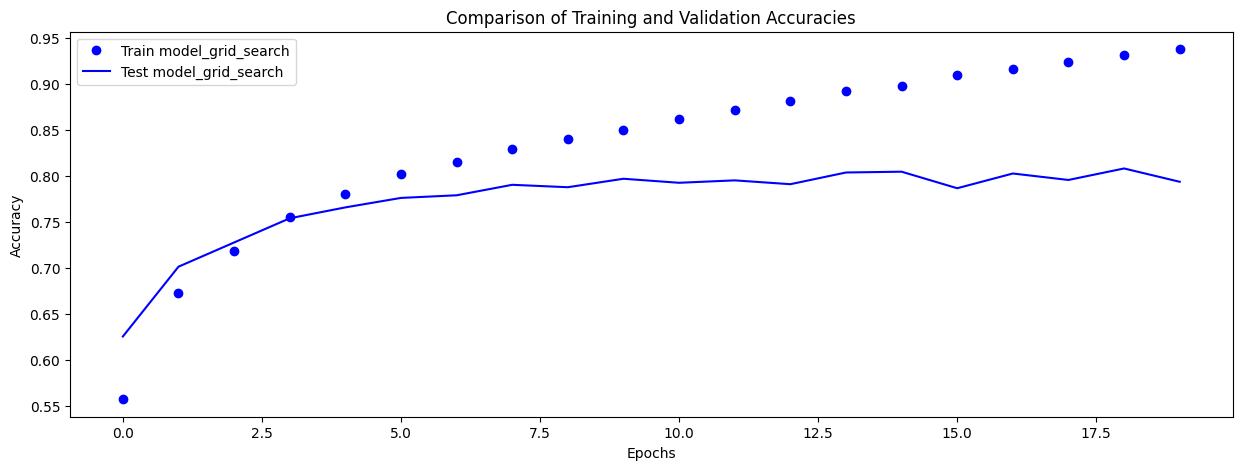

<Figure size 640x480 with 0 Axes>

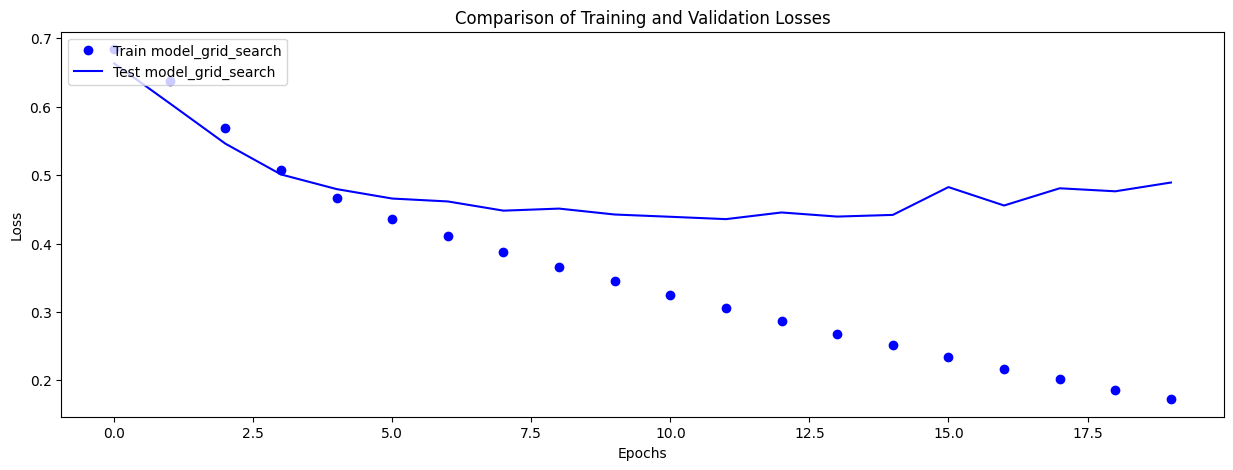

In [18]:
acc_model_grid_search = history_model_grid_search.history['acc']
val_acc_model_grid_search = history_model_grid_search.history['val_acc']
loss_model_grid_search = history_model_grid_search.history['loss']
val_loss_model_grid_search = history_model_grid_search.history['val_loss']

PlotAccuracyComparison(acc_model_grid_search, val_acc_model_grid_search, lab = 'model_grid_search')
PlotLossComparison(loss_model_grid_search, val_loss_model_grid_search, lab = 'model_grid_search')

179/179 [==============================] - 1s 4ms/step


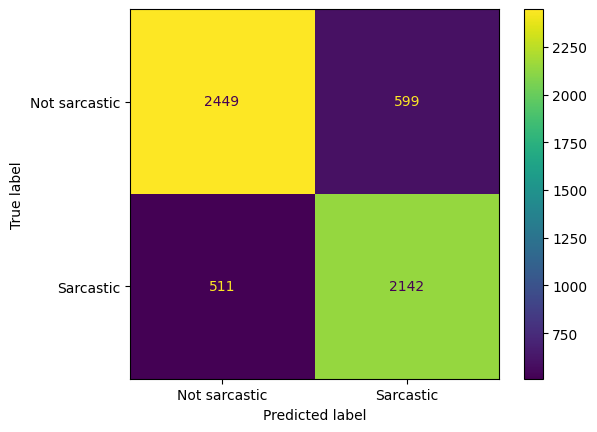

In [19]:
show_confusion_matrix(model_grid_search)

In [20]:
model_grid_search.evaluate(X_test, y_test)

179/179 [==============================] - 1s 6ms/step - loss: 0.4746 - acc: 0.8053


[0.4745573103427887, 0.805297315120697]

Widzimy, że faktycznie dany model jest najlepszym modelem LSTM porównując z modelami z poprzedniego notebooka. Udało nam się uzyskać niskie loss na zbiorze walidacyjnym osiągające w pewnym momencie wartość 0.43. Jak również nie zaczeło gwałtownie zwrastać po dobiciu do wartości około 0.5. Podobnie ma się to na zbiorze testowym. Wartości są bardzo zbliżone do tych ze zbioru walidacyjnego. Zapiszmy sobie ten model:

In [21]:
# The path to store trained models
models_dir = 'models/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

In [22]:
model_grid_search.save(models_dir + 'ModelGridSearch.h5')

## Bidirectional LSTM
Dotychczas szukaliśmy optymalnego modelu wśród prostych sieci 1D Conv oraz LSTM. Możemy pójść krok dalej i wykorzystać jeszcze inny rodzaj sieci rekurencyjnych. Bidrectional RNN ma na celu poprawić wydajność RNN w porządku chronologicznym: patrzy na sekwencję danych wejściowych w obie strony, uzyskując potencjalnie bogatsze reprezentacje i przechwytując wzorce, które mogły zostać pominięte przez samą wersję w porządku chronologicznym. Być może takie podejście pozwoli nam bardziej rozgryźć problem sarkazmu

In [24]:
model_bidirectional = Sequential()
model_bidirectional.add(layers.Embedding(input_dim=embedding_matrix.shape[0], 
     output_dim=embedding_matrix.shape[1], 
     weights = [embedding_matrix], input_length=maxlen))
model_bidirectional.add(layers.Bidirectional(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.001))))
model_bidirectional.add(layers.Dense(8, activation='relu'))
model_bidirectional.add(layers.Dense(1, activation='sigmoid'))

model_bidirectional.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history_model_bidirectional = model_bidirectional.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.2)

model_bidirectional.save(models_dir + 'Sarcasm_BidirectLSTM.h5')

Epoch 1/20
143/143 [==============================] - 9s 26ms/step - loss: 0.7043 - acc: 0.7302 - val_loss: 0.5258 - val_acc: 0.7854
Epoch 2/20
143/143 [==============================] - 2s 17ms/step - loss: 0.4440 - acc: 0.8313 - val_loss: 0.4896 - val_acc: 0.8027
Epoch 3/20
143/143 [==============================] - 2s 17ms/step - loss: 0.3537 - acc: 0.8721 - val_loss: 0.4700 - val_acc: 0.7985
Epoch 4/20
143/143 [==============================] - 2s 17ms/step - loss: 0.2889 - acc: 0.8983 - val_loss: 0.4718 - val_acc: 0.8040
Epoch 5/20
143/143 [==============================] - 2s 17ms/step - loss: 0.2424 - acc: 0.9167 - val_loss: 0.4952 - val_acc: 0.8090
Epoch 6/20
143/143 [==============================] - 2s 17ms/step - loss: 0.2053 - acc: 0.9317 - val_loss: 0.5238 - val_acc: 0.8090
Epoch 7/20
143/143 [==============================] - 3s 18ms/step - loss: 0.1740 - acc: 0.9438 - val_loss: 0.5664 - val_acc: 0.8007
Epoch 8/20
143/143 [==============================] - 3s 18ms/step - 

<Figure size 640x480 with 0 Axes>

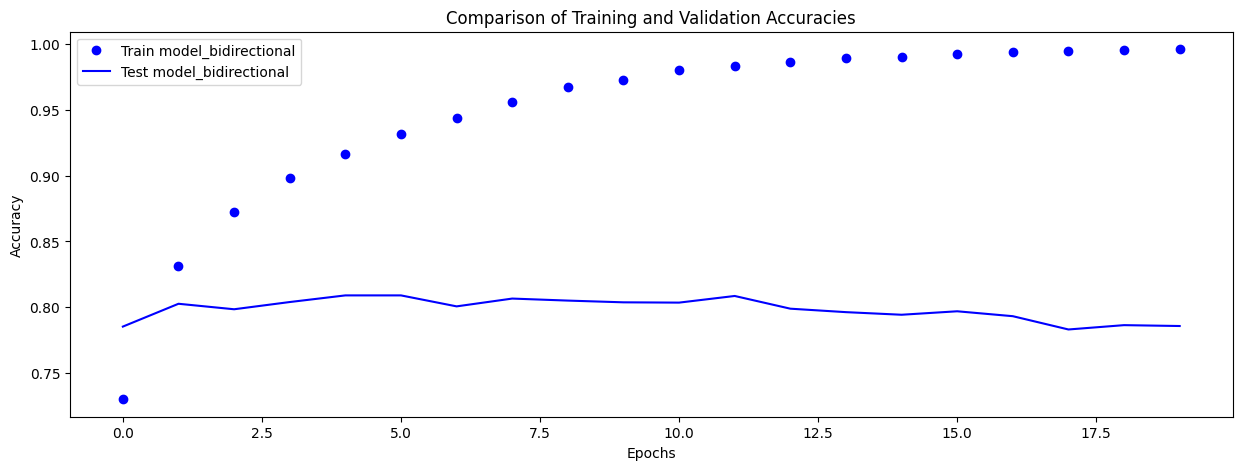

<Figure size 640x480 with 0 Axes>

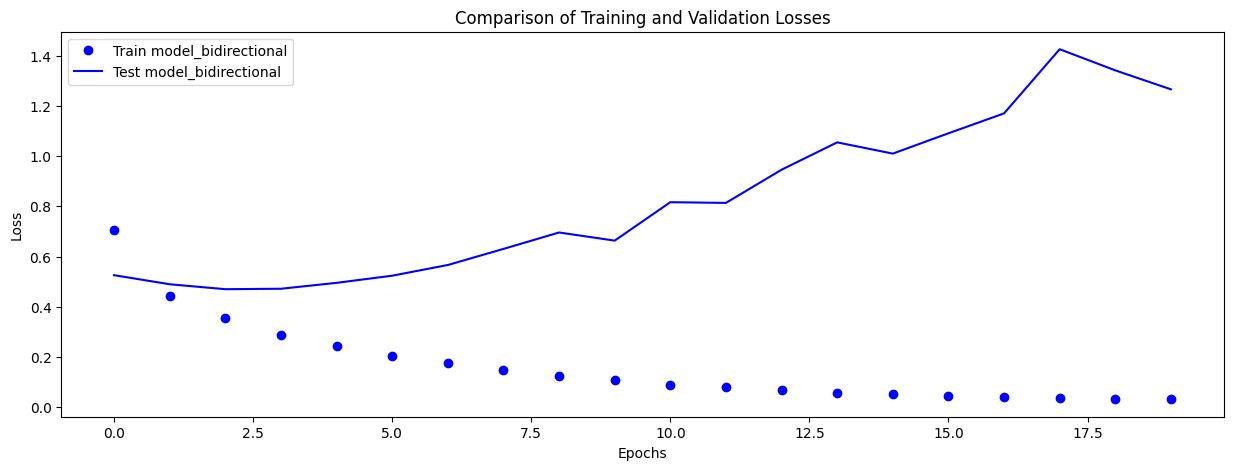

In [25]:
acc_model_bidirectional = history_model_bidirectional.history['acc']
val_acc_model_bidirectional = history_model_bidirectional.history['val_acc']
loss_model_bidirectional = history_model_bidirectional.history['loss']
val_loss_model_bidirectional = history_model_bidirectional.history['val_loss']

PlotAccuracyComparison(acc_model_bidirectional, val_acc_model_bidirectional, lab = 'model_bidirectional')
PlotLossComparison(loss_model_bidirectional, val_loss_model_bidirectional, lab = 'model_bidirectional')

W pewnym momencie uczenia osiągneliśmy 81% accuracy, jednak potem model zaczął się przeuczać i skuteczność spadła. Gdy popatrzymy na loss na zbiorze walidacyjnym doszliśmy do 0.5 po czym wartości zaczęły gwałtownie wzrastać (model zaczął się przeuczać). Sprawdźmy jak zachowa się dla optymalizatora: `Adam`

In [26]:
model_bidirectional = Sequential()
model_bidirectional.add(layers.Embedding(input_dim=embedding_matrix.shape[0], 
     output_dim=embedding_matrix.shape[1], 
     weights = [embedding_matrix], input_length=maxlen))
model_bidirectional.add(layers.Bidirectional(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.001))))
model_bidirectional.add(layers.Dense(8, activation='relu'))
model_bidirectional.add(layers.Dense(1, activation='sigmoid'))

model_bidirectional.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
history_model_bidirectional = model_bidirectional.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.2)

model_bidirectional.save(models_dir + 'Sarcasm_BidirectLSTM.h5')

Epoch 1/20
143/143 [==============================] - 9s 26ms/step - loss: 0.7115 - acc: 0.7372 - val_loss: 0.5206 - val_acc: 0.7948
Epoch 2/20
143/143 [==============================] - 3s 19ms/step - loss: 0.3859 - acc: 0.8642 - val_loss: 0.4652 - val_acc: 0.8117
Epoch 3/20
143/143 [==============================] - 3s 19ms/step - loss: 0.2428 - acc: 0.9221 - val_loss: 0.5307 - val_acc: 0.8130
Epoch 4/20
143/143 [==============================] - 3s 19ms/step - loss: 0.1571 - acc: 0.9578 - val_loss: 0.6464 - val_acc: 0.8031
Epoch 5/20
143/143 [==============================] - 3s 20ms/step - loss: 0.1081 - acc: 0.9763 - val_loss: 0.6867 - val_acc: 0.8077
Epoch 6/20
143/143 [==============================] - 3s 19ms/step - loss: 0.0852 - acc: 0.9817 - val_loss: 0.8544 - val_acc: 0.7965
Epoch 7/20
143/143 [==============================] - 3s 20ms/step - loss: 0.0684 - acc: 0.9880 - val_loss: 0.9224 - val_acc: 0.8042
Epoch 8/20
143/143 [==============================] - 3s 19ms/step - 

<Figure size 640x480 with 0 Axes>

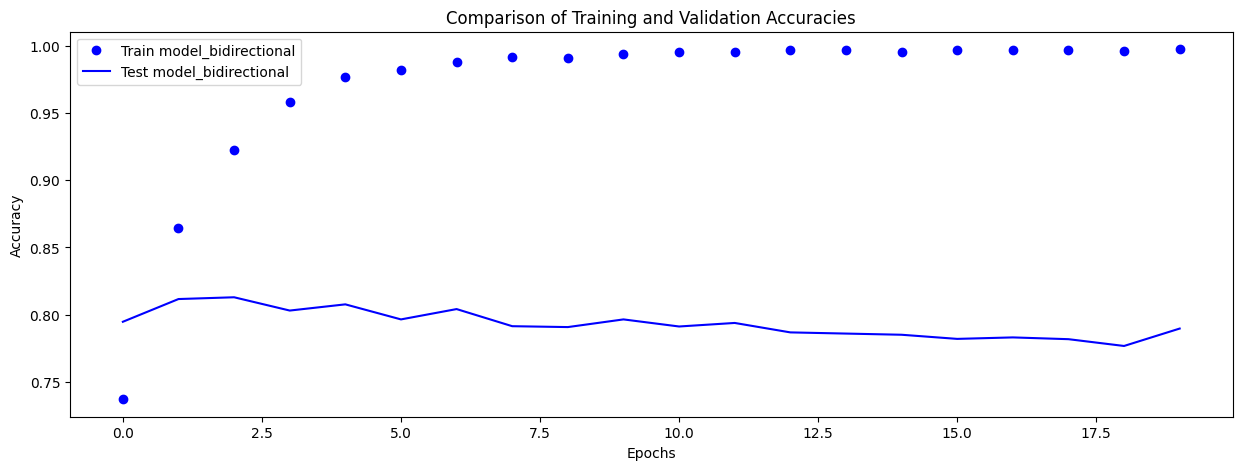

<Figure size 640x480 with 0 Axes>

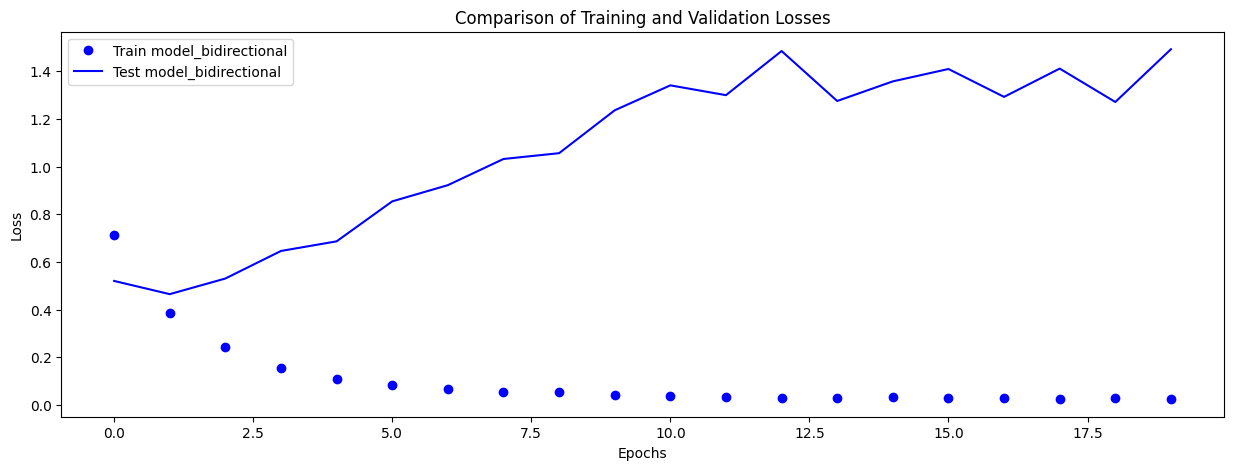

In [27]:
acc_model_bidirectional = history_model_bidirectional.history['acc']
val_acc_model_bidirectional = history_model_bidirectional.history['val_acc']
loss_model_bidirectional = history_model_bidirectional.history['loss']
val_loss_model_bidirectional = history_model_bidirectional.history['val_loss']

PlotAccuracyComparison(acc_model_bidirectional, val_acc_model_bidirectional, lab = 'model_bidirectional')
PlotLossComparison(loss_model_bidirectional, val_loss_model_bidirectional, lab = 'model_bidirectional')

Zmiana optymizatora nie wpłynęła na proces uczenia, nadal mamy do czynienia z takim samym problemem jak wcześniej - z dużym overfittingiem. Patrząc na proces uczenia, możemy dostrzec, że po 3 epokach model się przeucza, więc uczmy nasz model przez 3 epoki

In [28]:
model_bidirectional = Sequential()
model_bidirectional.add(layers.Embedding(input_dim=embedding_matrix.shape[0], 
     output_dim=embedding_matrix.shape[1], 
     weights = [embedding_matrix], input_length=maxlen))
model_bidirectional.add(layers.Bidirectional(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.001))))
model_bidirectional.add(layers.Dense(8, activation='relu'))
model_bidirectional.add(layers.Dense(1, activation='sigmoid'))

model_bidirectional.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
history_model_bidirectional = model_bidirectional.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.2)

model_bidirectional.save(models_dir + 'Sarcasm_BidirectLSTM.h5')

Epoch 1/3
143/143 [==============================] - 10s 30ms/step - loss: 0.7199 - acc: 0.7249 - val_loss: 0.5225 - val_acc: 0.7816
Epoch 2/3
143/143 [==============================] - 3s 19ms/step - loss: 0.3886 - acc: 0.8593 - val_loss: 0.4546 - val_acc: 0.8079
Epoch 3/3
143/143 [==============================] - 3s 19ms/step - loss: 0.2507 - acc: 0.9174 - val_loss: 0.5180 - val_acc: 0.8141


In [29]:
model_bidirectional.evaluate(X_test, y_test)

179/179 [==============================] - 1s 6ms/step - loss: 0.5062 - acc: 0.8158


[0.5062038898468018, 0.8158217668533325]

Uzyskaliśmy loss mniej więcej porównywalny z modelem LSTM nauczonym wcześniej. Skuteczność modelu też jest większa - wynosi prawie 82%, czyli o 2% więcej. Jest to już w miarę satysfakcjonujący wynik patrząc na specyfikę problemu, który próbujemy rozwiązać. Jednak spróbujmy wykrzesać jeszcze więcej i odpowiednio dobrać hiperparametry, żeby uzyskać jeszcze lepszy wynik.

Zacznijmy od regularyzacji modelu, gdyż po 3 epokach łatwo się przeucza:

In [30]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [31]:
from keras.callbacks import EarlyStopping
model_bidirectional = Sequential()
model_bidirectional.add(layers.Embedding(input_dim=embedding_matrix.shape[0], 
     output_dim=embedding_matrix.shape[1], 
     weights = [embedding_matrix], input_length=maxlen))
model_bidirectional.add(layers.Bidirectional(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.001))))
model_bidirectional.add(layers.Dropout(0.5)) #+
model_bidirectional.add(layers.Dense(8, activation='relu'))
model_bidirectional.add(layers.Dropout(0.5)) #+
model_bidirectional.add(layers.Dense(1, activation='sigmoid'))
model_bidirectional.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
history_model_bidirectional = model_bidirectional.fit(X_train_, y_train_, epochs=10, batch_size=128, validation_data=(X_val, y_val))

model_bidirectional.save(models_dir + 'Sarcasm_BidirectLSTM.h5')

Epoch 1/10
143/143 [==============================] - 10s 28ms/step - loss: 0.7746 - acc: 0.6782 - val_loss: 0.5215 - val_acc: 0.7869
Epoch 2/10
143/143 [==============================] - 3s 19ms/step - loss: 0.4774 - acc: 0.8122 - val_loss: 0.4508 - val_acc: 0.8185
Epoch 3/10
143/143 [==============================] - 3s 20ms/step - loss: 0.3462 - acc: 0.8724 - val_loss: 0.5183 - val_acc: 0.8117
Epoch 4/10
143/143 [==============================] - 3s 19ms/step - loss: 0.2661 - acc: 0.9047 - val_loss: 0.5995 - val_acc: 0.8053
Epoch 5/10
143/143 [==============================] - 3s 20ms/step - loss: 0.2086 - acc: 0.9274 - val_loss: 0.6365 - val_acc: 0.8062
Epoch 6/10
143/143 [==============================] - 3s 19ms/step - loss: 0.1737 - acc: 0.9373 - val_loss: 0.8303 - val_acc: 0.7987
Epoch 7/10
143/143 [==============================] - 3s 19ms/step - loss: 0.1499 - acc: 0.9453 - val_loss: 0.7474 - val_acc: 0.8053
Epoch 8/10
143/143 [==============================] - 3s 19ms/step -

<Figure size 640x480 with 0 Axes>

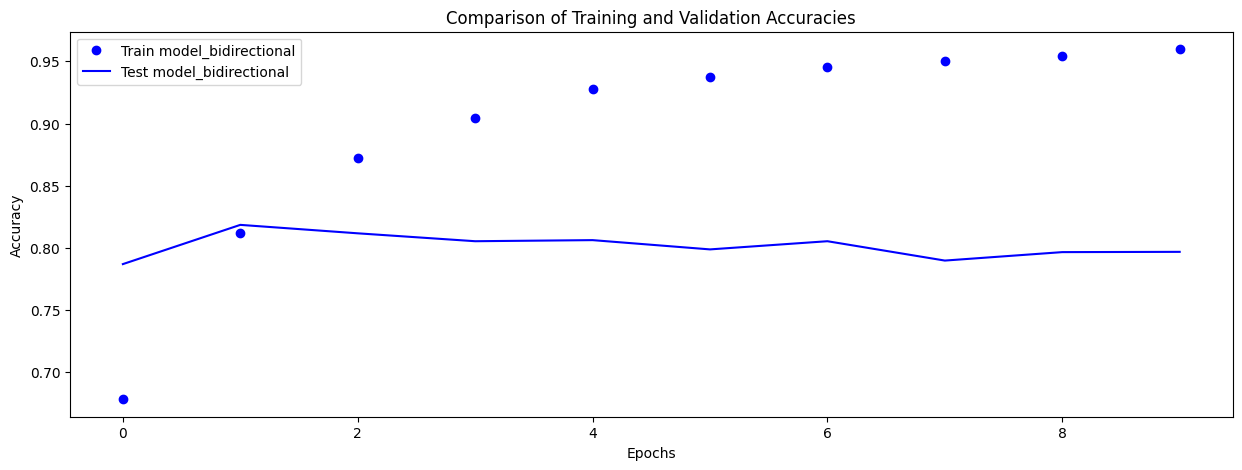

<Figure size 640x480 with 0 Axes>

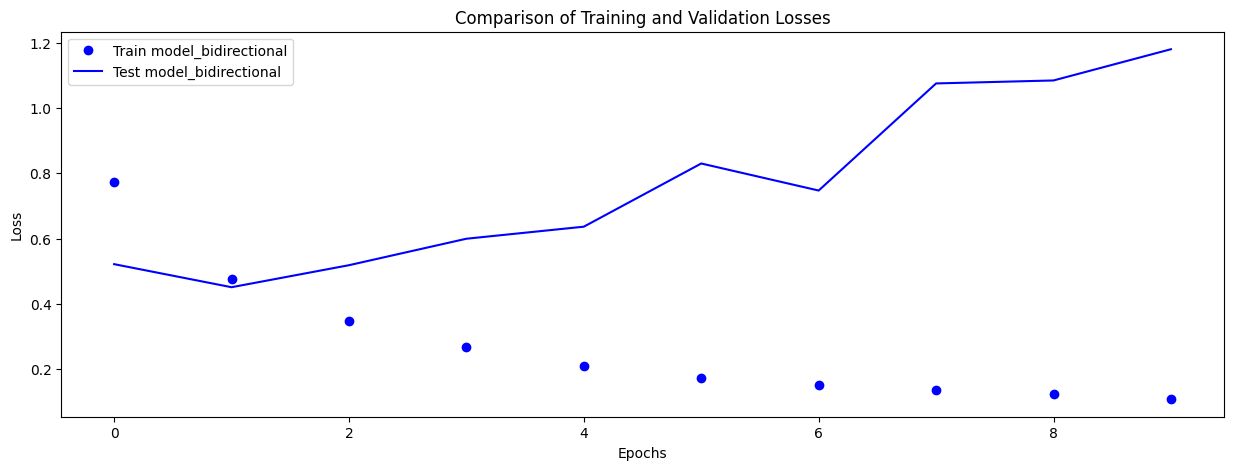

In [32]:
acc_model_bidirectional = history_model_bidirectional.history['acc']
val_acc_model_bidirectional = history_model_bidirectional.history['val_acc']
loss_model_bidirectional = history_model_bidirectional.history['loss']
val_loss_model_bidirectional = history_model_bidirectional.history['val_loss']

PlotAccuracyComparison(acc_model_bidirectional, val_acc_model_bidirectional, lab = 'model_bidirectional')
PlotLossComparison(loss_model_bidirectional, val_loss_model_bidirectional, lab = 'model_bidirectional')

179/179 [==============================] - 2s 6ms/step


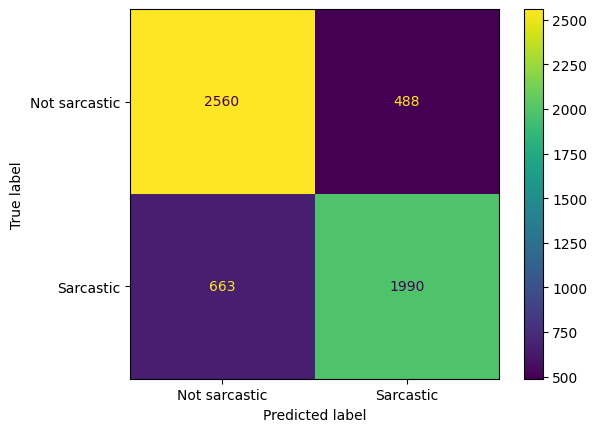

In [33]:
show_confusion_matrix(model_bidirectional)

Zmodyfikujmy jeszcze regularyzację L2:

In [35]:
model_bidirectional = Sequential()
model_bidirectional.add(layers.Embedding(input_dim=embedding_matrix.shape[0], 
     output_dim=embedding_matrix.shape[1], 
     weights = [embedding_matrix], input_length=maxlen))
model_bidirectional.add(layers.Bidirectional(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.00001))))
model_bidirectional.add(layers.Dropout(0.5)) #+
model_bidirectional.add(layers.Dense(8, activation='relu'))
model_bidirectional.add(layers.Dropout(0.5)) #+
model_bidirectional.add(layers.Dense(1, activation='sigmoid'))
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model_bidirectional.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['acc'])
history_model_bidirectional = model_bidirectional.fit(X_train_, y_train_, epochs=10, batch_size=128, validation_data=(X_val, y_val))

model_bidirectional.save(models_dir + 'Sarcasm_BidirectLSTM.h5')

Epoch 1/10
143/143 [==============================] - 9s 28ms/step - loss: 0.5951 - acc: 0.6804 - val_loss: 0.4578 - val_acc: 0.7957
Epoch 2/10
143/143 [==============================] - 3s 20ms/step - loss: 0.4165 - acc: 0.8213 - val_loss: 0.4022 - val_acc: 0.8204
Epoch 3/10
143/143 [==============================] - 3s 19ms/step - loss: 0.3048 - acc: 0.8774 - val_loss: 0.4177 - val_acc: 0.8310
Epoch 4/10
143/143 [==============================] - 3s 20ms/step - loss: 0.2103 - acc: 0.9158 - val_loss: 0.5019 - val_acc: 0.8200
Epoch 5/10
143/143 [==============================] - 3s 20ms/step - loss: 0.1560 - acc: 0.9354 - val_loss: 0.6478 - val_acc: 0.8176
Epoch 6/10
143/143 [==============================] - 3s 19ms/step - loss: 0.1173 - acc: 0.9507 - val_loss: 0.9121 - val_acc: 0.8029
Epoch 7/10
143/143 [==============================] - 3s 19ms/step - loss: 0.0942 - acc: 0.9578 - val_loss: 1.0417 - val_acc: 0.8176
Epoch 8/10
143/143 [==============================] - 3s 20ms/step - 

<Figure size 640x480 with 0 Axes>

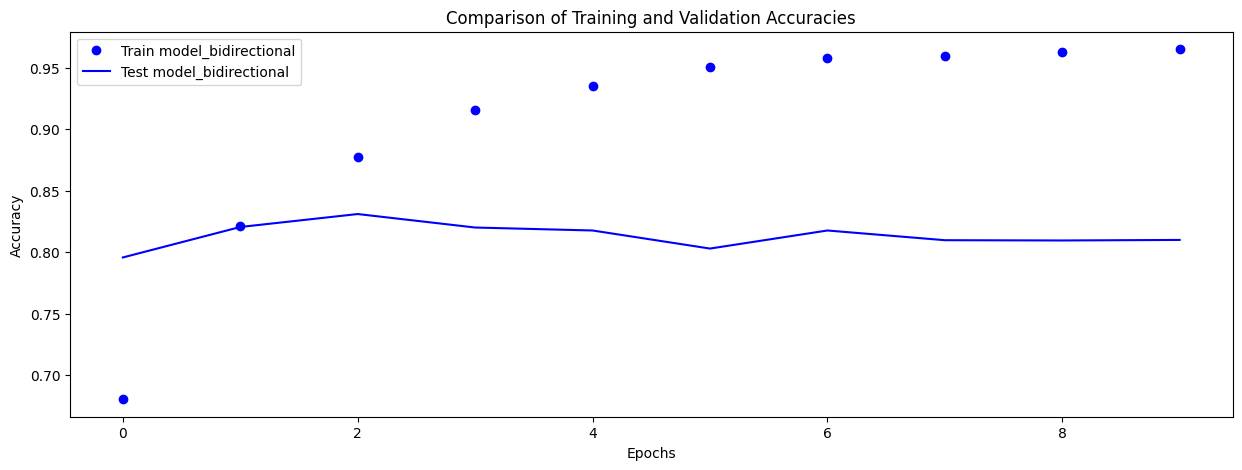

<Figure size 640x480 with 0 Axes>

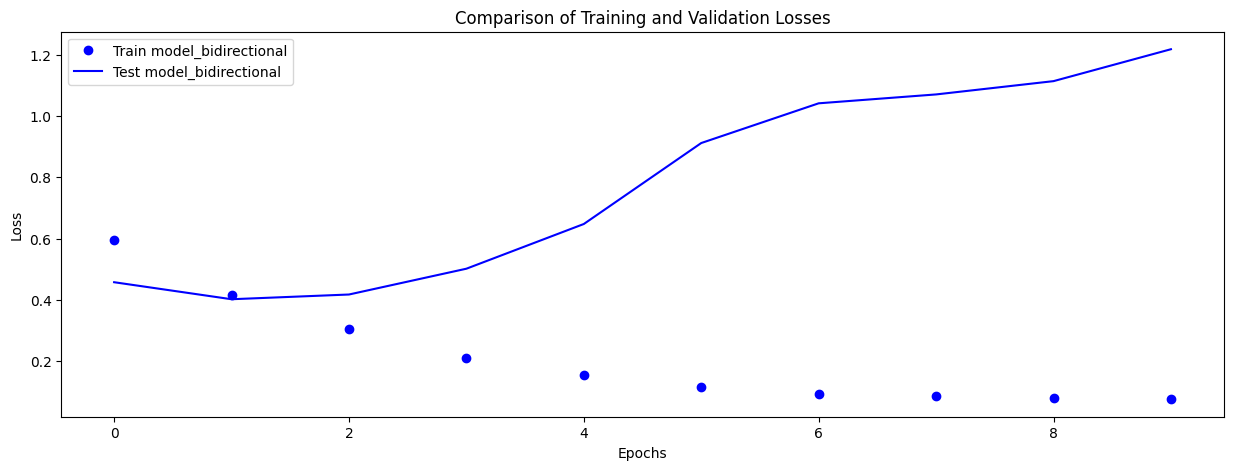

In [36]:
acc_model_bidirectional = history_model_bidirectional.history['acc']
val_acc_model_bidirectional = history_model_bidirectional.history['val_acc']
loss_model_bidirectional = history_model_bidirectional.history['loss']
val_loss_model_bidirectional = history_model_bidirectional.history['val_loss']

PlotAccuracyComparison(acc_model_bidirectional, val_acc_model_bidirectional, lab = 'model_bidirectional')
PlotLossComparison(loss_model_bidirectional, val_loss_model_bidirectional, lab = 'model_bidirectional')

179/179 [==============================] - 2s 5ms/step


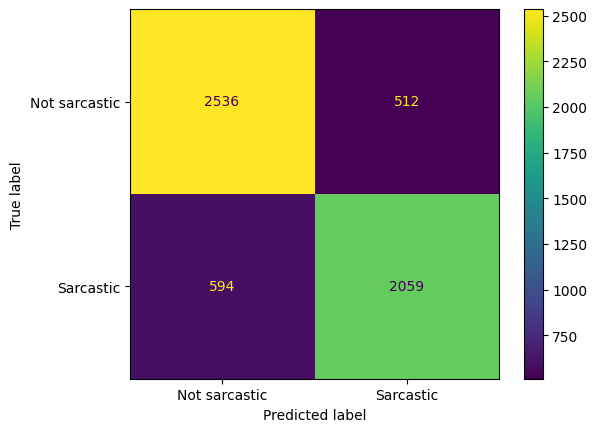

In [37]:
show_confusion_matrix(model_bidirectional)

Modyfikacja regularyzacji L2 przyniosła zamierzony efekt. Widzimy, że udało nam się zmniejszyć loss na zbiorze walidacyjnym po 2 epokach do 0.4. Potem oczywiście występuje overfitting. Spróbujmy zmniejszyć learning_rate, żeby proces uczenia trwał dłużej i overfitting nie następował tak szybko:

In [39]:
model_bidirectional = Sequential()
model_bidirectional.add(layers.Embedding(input_dim=embedding_matrix.shape[0], 
     output_dim=embedding_matrix.shape[1], 
     weights = [embedding_matrix], input_length=maxlen))
model_bidirectional.add(layers.Bidirectional(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.00001))))
model_bidirectional.add(layers.Dropout(0.5)) #+
model_bidirectional.add(layers.Dense(8, activation='relu'))
model_bidirectional.add(layers.Dropout(0.5)) #+
model_bidirectional.add(layers.Dense(1, activation='sigmoid'))
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model_bidirectional.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['acc'])
history_model_bidirectional = model_bidirectional.fit(X_train_, y_train_, epochs=10, batch_size=128, validation_data=(X_val, y_val))

model_bidirectional.save(models_dir + 'Sarcasm_BidirectLSTM_300d.h5')

Epoch 1/10
143/143 [==============================] - 8s 28ms/step - loss: 0.6037 - acc: 0.6750 - val_loss: 0.4577 - val_acc: 0.7904
Epoch 2/10
143/143 [==============================] - 3s 19ms/step - loss: 0.4344 - acc: 0.8297 - val_loss: 0.4064 - val_acc: 0.8163
Epoch 3/10
143/143 [==============================] - 3s 19ms/step - loss: 0.3223 - acc: 0.8898 - val_loss: 0.4345 - val_acc: 0.8171
Epoch 4/10
143/143 [==============================] - 3s 19ms/step - loss: 0.2468 - acc: 0.9256 - val_loss: 0.4765 - val_acc: 0.8163
Epoch 5/10
143/143 [==============================] - 3s 22ms/step - loss: 0.1869 - acc: 0.9514 - val_loss: 0.5582 - val_acc: 0.8163
Epoch 6/10
143/143 [==============================] - 3s 23ms/step - loss: 0.1510 - acc: 0.9632 - val_loss: 0.7606 - val_acc: 0.8119
Epoch 7/10
143/143 [==============================] - 3s 19ms/step - loss: 0.1230 - acc: 0.9737 - val_loss: 0.8584 - val_acc: 0.8123
Epoch 8/10
143/143 [==============================] - 3s 20ms/step - 

<Figure size 640x480 with 0 Axes>

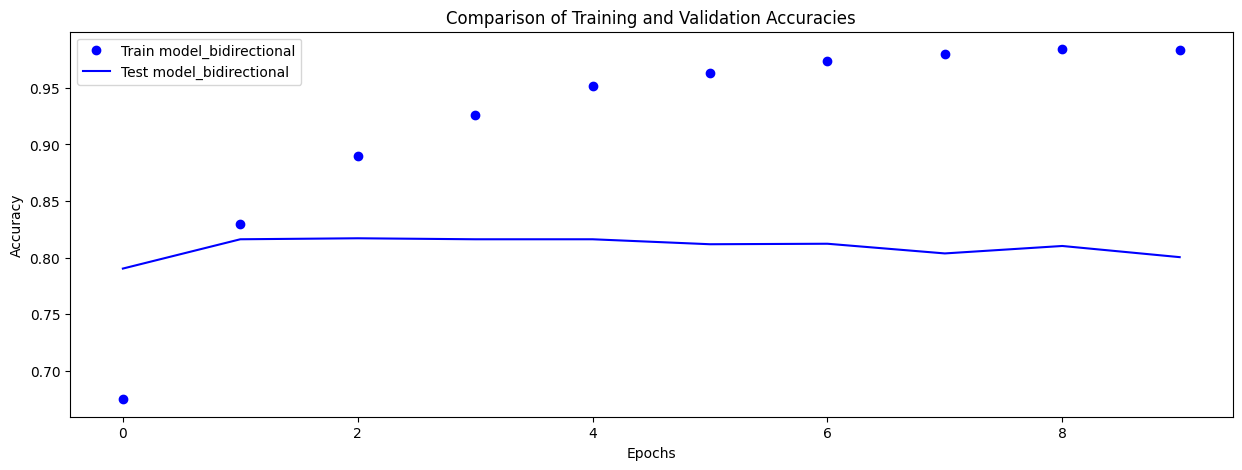

<Figure size 640x480 with 0 Axes>

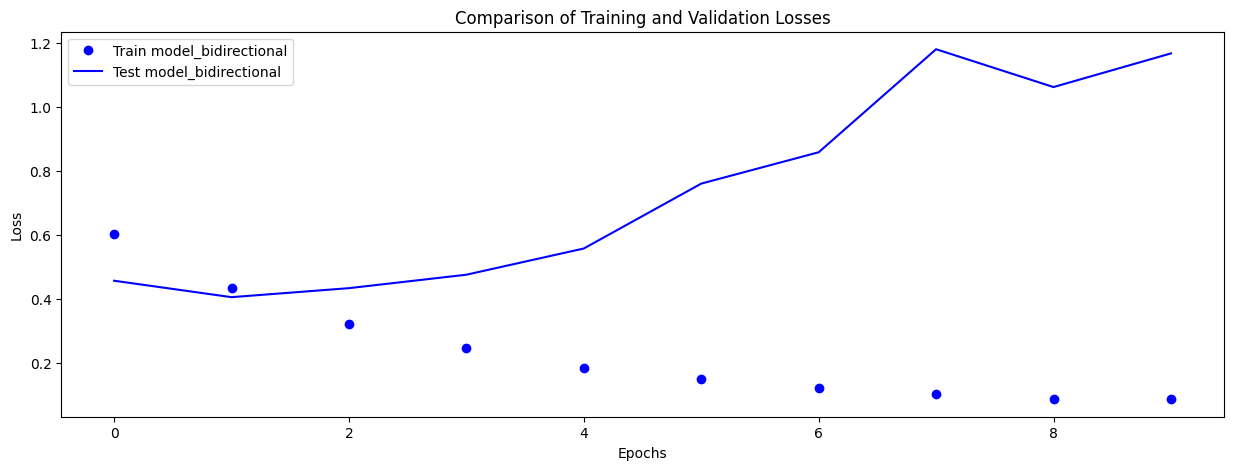

In [40]:
acc_model_bidirectional = history_model_bidirectional.history['acc']
val_acc_model_bidirectional = history_model_bidirectional.history['val_acc']
loss_model_bidirectional = history_model_bidirectional.history['loss']
val_loss_model_bidirectional = history_model_bidirectional.history['val_loss']

PlotAccuracyComparison(acc_model_bidirectional, val_acc_model_bidirectional, lab = 'model_bidirectional')
PlotLossComparison(loss_model_bidirectional, val_loss_model_bidirectional, lab = 'model_bidirectional')

179/179 [==============================] - 2s 5ms/step


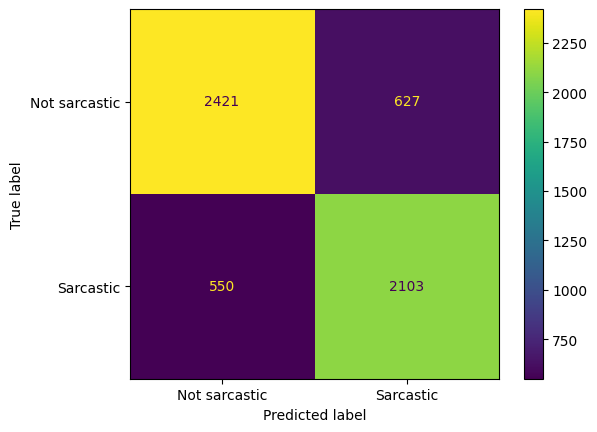

In [41]:
show_confusion_matrix(model_bidirectional)

Możemy dostrzec, że model i tak przeucza się po 2/3 epokach. Zakończym więc proces uczenia po 2 epokach i zweryfikujmy wyniki

In [42]:
model_bidirectional = Sequential()
model_bidirectional.add(layers.Embedding(input_dim=embedding_matrix.shape[0], 
     output_dim=embedding_matrix.shape[1], 
     weights = [embedding_matrix], input_length=maxlen))
model_bidirectional.add(layers.Bidirectional(layers.LSTM(64, kernel_regularizer=regularizers.l2(0.00001))))
model_bidirectional.add(layers.Dropout(0.5)) #+
model_bidirectional.add(layers.Dense(8, activation='relu'))
model_bidirectional.add(layers.Dropout(0.5)) #+
model_bidirectional.add(layers.Dense(1, activation='sigmoid'))
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model_bidirectional.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['acc'])
history_model_bidirectional = model_bidirectional.fit(X_train_, y_train_, epochs=2, batch_size=128, validation_data=(X_val, y_val))

model_bidirectional.save(models_dir + 'Sarcasm_BidirectLSTM_300d.h5')

Epoch 1/2
143/143 [==============================] - 10s 27ms/step - loss: 0.6049 - acc: 0.6731 - val_loss: 0.4640 - val_acc: 0.7882
Epoch 2/2
143/143 [==============================] - 3s 19ms/step - loss: 0.4223 - acc: 0.8261 - val_loss: 0.3983 - val_acc: 0.8204


179/179 [==============================] - 2s 5ms/step


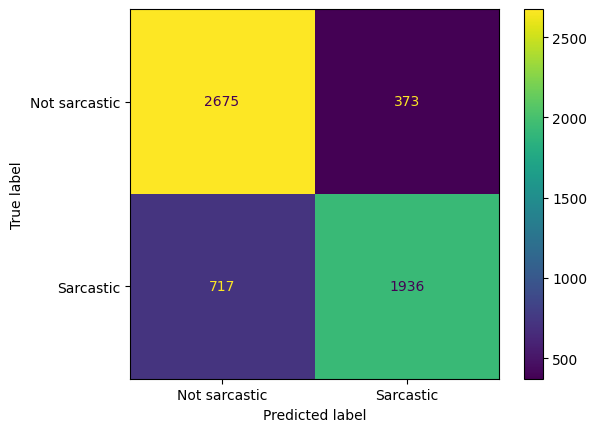

In [44]:
show_confusion_matrix(model_bidirectional)

In [45]:
model_bidirectional.evaluate(X_test, y_test)

179/179 [==============================] - 1s 7ms/step - loss: 0.4101 - acc: 0.8088


[0.41006216406822205, 0.8088054656982422]

# Wnioski:
- lematyzacja ani stemming nie są potrzebne w przypadku sarkazmu. W tym specyficznym problemie każdy znak ma istotne znaczenie w celu poprawnego zaklasyfikowania wiadomości
- sieci 1d convnet spisały się bardzo dobrze dla tego problemu. Nie przeuczały się znacząco, a val_loss był nie wiele większy od bardziej zaawansowanych sieci LSTM i bidirect LSTM. 
- proste sieci RNN szybko się przeuczały tak samo jak LSTM. Jednak poprzez dostrojenie hiperparametrów modelu opatego LSTM oraz przez przeszukanie siatki hiperparametrów udało się w miarę dostroić ten model. Uzyskaliśmy skuteczność na poziomie 80/81%
- najlepiej dla tego problemu sprawdziła się sieć bidirectional LSTM. Dzięki dodaniu regularyzacj, spowolnieniu uczenia i zmniejszenia liczby epok udało się uzyskać bardzo niski val_loss porównując z wszystkimi wcześniejszymi sieciami (0.39), a także wysoką skuteczność: 82% na zbiorze walidacyjnym, 81% na zbiorze testowym